In [36]:
import numpy as np
import pandas as pd
import scipy 
import random
import matplotlib.pyplot as plt
from numpy import matlib
import seaborn as sns
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib_inline
import matplotlib
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import datetime

## Organize data

In [37]:
# motor and value areas functional connectivity matrix
motor_value_mat = pd.read_csv('../data//motor_value_fc_matrix_separated_with__.csv', index_col = 'Subject')
# whole-brain functional connectivity matrix 
schaefer_mat = pd.read_csv('../data/schaefer_fc_matrix_separated_with__.csv', index_col = 'Subject')
# inconsistency measures: GARP, Varian, Afriat, Houtman-Maks, MMI
behavioral_results = pd.read_csv('../data/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')

In [38]:
X = motor_value_mat
# choose only subjects that did a resting scan
Ys = behavioral_results.loc[motor_value_mat.index]
# shorten names of variables
Ys = Ys.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']
# remove perfectly-consistent subjects
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

In [39]:
# Y's correlation matrix
Ys_incon.loc[:, all_measures].corr()

,GARP Violations,Afriat Index,Varian Index,Houtman Maks Index,MMI
GARP Violations,1.000000,0.921912,0.971916,0.884189,0.798927
Afriat Index,0.921912,1.000000,0.981164,0.904014,0.831654
Varian Index,0.971916,0.981164,1.000000,0.911739,0.817753
Houtman Maks Index,0.884189,0.904014,0.911739,1.000000,0.875786
MMI,0.798927,0.831654,0.817753,0.875786,1.000000


## Functions

In [40]:
def select_features(X, y, pval_thresh, number_thresh = 0):
    '''
    Feature selection function. Selects the top features (X) that are most correlated with y, in absolute value.
    Thresholding can be done using correlation's p value or number of top features.
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - numpy float array
                target vairable
            pval_tresh - float
                threshold of correlations' p value to include in the selected features
            number_thresh -  int
                number of features to select
            
    Returns
    ----------------------------
            top_features - string list
                list of the selected features 
    '''
    if number_thresh != 0:
        # select top features using number_thresh
        column_len = len(X.columns)
        # create matrix of repeated Ys in the size of len(X) x len(Y)
        y_mat = np.matlib.repmat(y, column_len, 1)
        # correlate between X and Y save absolute values
        x_y_corr = np.corrcoef(X.transpose(), y_mat)
        abs_corr = np.abs(x_y_corr)
        # sort features and select the top number_thresh features
        top_indices = np.argsort(abs_corr[column_len, 0:column_len])
        top_features = X.columns[top_indices[-1 * number_thresh:]]
    else:
        # select top features using p-value
        top_features = []
        corrs = []
        # calculate the correlation of each feature with y, choose only correlations with p-value < pval_thresh
        for feature in X.columns:
            feature_data = X.loc[:, feature]
            r, pval = correlation_permuation_test(feature_data, y)
            if pval < pval_thresh:
                top_features.append(feature)
                corrs.append(r)
    return top_features

In [115]:
measure = 'Afriat Index'
model_type='RandomForest'
X = schaefer_mat.loc[inconsistent_subjects, :]
y = Ys_incon
k_cv=33
feature_number=45
scale_x=1 

models = []
scores = []
y = np.log(y.loc[:, measure])
n_estimators = np.linspace(60, 250, 10, dtype=int)
n_estimators = np.insert(n_estimators, 0, 100)
max_features = ['auto', 'sqrt']
max_depth = np.linspace(10, 100, 5, dtype=int)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2]
learning_rate = [0.001, 0.01, 0.1]
if model_type == 'RandomForest':
    param_grid = {'n_estimators' : n_estimators,
                    'max_features' : max_features,
                    'max_depth' : max_depth,
                    'min_samples_split' : min_samples_split,
                    'min_samples_leaf' : min_samples_leaf}
    model = RandomForestRegressor(n_jobs = -1, random_state = 42)
    # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 4000, 
                            #    cv = 3, n_jobs = -1, random_state = 42)
    model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv, scoring='neg_mean_squared_error')
elif model_type == 'Xgboost':
    model = xgb.XGBRegressor()
    param_grid = {'n_estimators' : n_estimators,
                    'max_depth' : np.linspace(2, 8, 4, dtype=int),
                    'learning_rate' : learning_rate}
    # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 100, 
                        #   cv = k_cv, n_jobs = -1, random_state = 42)
    model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=None, cv=k_cv, scoring='neg_mean_squared_error')

# features = X.columns
# features = features.append(pd.Index(['Score']))
# coef_df = pd.DataFrame(features, columns = ['Feature'])
coefs_list = []

loo = model_selection.LeaveOneOut()
i = 1
y_hats = []
y_true = []
coefs_list = []
for train_ind, test_ind in loo.split(X):
    current_time = datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S %D')
    print(f'Fold: {i}/{len(y)}, Time: {current_time}')
    X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    if feature_number!=0:
        selected_features = select_features(X_train, y_train, 0.05, feature_number)
        X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]
    if scale_x == 1:
        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
    if scale_x == 2:
        # scaling X by feature
        X_mean = np.mean(X_train)
        X_std = np.std(X_train)
        X_train = (X_train - X_mean) / X_std
        # we use mean and std from train
        X_test = (X_test - X_mean) / X_std
    # scale y_train
    mean_y = np.mean(y_train)
    std_y = np.std(y_train)
    y_train = (y_train - mean_y) / std_y
    # scale y_test with *y_train*
    y_test = (y_test - mean_y) / std_y
    
    model_cv.fit(X_train, y_train)
    best_model = model_cv.best_estimator_
    
    y_pred = best_model.predict(X_test)
    models.append((best_model, X_train))
    score = metrics.mean_squared_error(y_test, y_pred)
    y_hats.append(y_pred[0])
    y_true.append(y_test.values[0])
    
    features = X_train.columns
    features = features.append(pd.Index(['Score']))
    coef_df = pd.DataFrame(features, columns = ['Feature'])
    # coefs = model.coef_
    coefs = pd.DataFrame(best_model.feature_importances_)
    coef_df['Coefficient' + str(i)] = np.append(coefs, score)
    coefs_list.append(coef_df)
    i += 1

Fold: 1/34, Time: 12:12:20 04/05/22
Fold: 2/34, Time: 12:18:37 04/05/22


KeyboardInterrupt: 

In [144]:
def random_forest_model(X, y, measure, model_type, k_cv=3, scale_x=1, feature_number=0):
    
    models = []
    scores = []
    y = np.log(y.loc[:, measure])
    n_estimators = np.linspace(60, 250, 10, dtype=int)
    n_estimators = np.insert(n_estimators, 0, 100)
    max_features = ['auto', 'sqrt']
    max_depth = np.linspace(10, 100, 5, dtype=int)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2]
    learning_rate = [0.001, 0.01, 0.1]
    if model_type == 'RandomForest':
        param_grid = {'n_estimators' : n_estimators,
                     'max_features' : max_features,
                     'max_depth' : max_depth,
                     'min_samples_split' : min_samples_split,
                     'min_samples_leaf' : min_samples_leaf}
        model = RandomForestRegressor(n_jobs = -1, random_state = 42)
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 4000, 
                                #    cv = 3, n_jobs = -1, random_state = 42)
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv, scoring='neg_mean_squared_error')
    elif model_type == 'Xgboost':
        model = xgb.XGBRegressor()
        param_grid = {'n_estimators' : n_estimators,
                      'max_depth' : np.linspace(2, 8, 4, dtype=int),
                      'learning_rate' : learning_rate}
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 100, 
                            #   cv = k_cv, n_jobs = -1, random_state = 42)
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=None, cv=k_cv, scoring='neg_mean_squared_error')
    
    # features = X.columns
    # features = features.append(pd.Index(['Score']))
    # coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        current_time = datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S %D')
        print(f'Fold: {i}/{len(y)}, Time: {current_time}')
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        if feature_number!=0:
            selected_features = select_features(X_train, y_train, 0.05, feature_number)
            X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]
        if scale_x == 1:
            # scaling X by subject
            X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
            X_train = X_train.transpose()
            # scaling by subject therefore using X_test mean and SD
            X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
            X_test = X_test.transpose()
        if scale_x == 2:
            # scaling X by feature
            X_mean = np.mean(X_train)
            X_std = np.std(X_train)
            X_train = (X_train - X_mean) / X_std
            # we use mean and std from train
            X_test = (X_test - X_mean) / X_std
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model_cv.fit(X_train, y_train)
        best_model = model_cv.best_estimator_
        
        y_pred = best_model.predict(X_test)
        models.append((best_model, X_train))
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])
        # coefs = model.coef_
        coefs = pd.DataFrame(best_model.feature_importances_)
        coef_df['Coefficient'] = np.append(coefs, score)
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [41]:
def linear_models(X, y, measure, model_type, feature_number, k_cv=3):
    '''
    Trains a model: Linear, LASSO, Ridge, ElasticNet, or Random Forest. 
    Split train/test, selects features and predicts in with a leave-one-out procedure
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - pandas DataFrame
                DataFrame of target vairables
            measure - string
                name of target variable
            model_type - string
                string of model type, either:
                    'Linear' - regular linear regression
                    'Lasso' - LASSO regression
                    'Ridge' - Ridge regression
                    'Elastic' - ElasticNet regression
                    'Random Forest' - Random Forest regression
            feature_number - int
                number of features to select

    Returns
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
            y_hats - float array
                predicted target values
            y_true - float array
                true target values
            models - sklearn regressors list
                list of models used in the leave-one-out procedure
    '''
    
    models = []
    scores = []
    # transform y top log(y)
    y = np.log(y.loc[:, measure])
    
    # initiate models, based on model_type
    if model_type == 'Elastic':
        model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.01, 1, 0.02), cv = k_cv, alphas = np.arange(0.01, 1, 0.01), max_iter=50000, n_jobs = -1)
    elif model_type == 'Ridge': 
        model = linear_model.RidgeCV(alphas = np.arange(0.01, 5, 0.01), cv = k_cv)
    elif model_type == 'Lasso': 
        model = linear_model.LassoCV(alphas = np.arange(0.01, 5, 0.01), cv = k_cv, max_iter = 50000, n_jobs = -1)
    elif model_type == 'Linear':
        model = linear_model.LinearRegression(n_jobs = -1)

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        # select top N features with highest correlation with y_train
        selected_features = select_features(X_train, y_train, 0.05, feature_number)
        X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        # save the models, scores and predicted values
        models.append(model)
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        # save model's coefficients in DataFrame

        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])
        coefs = model.coef_
        coef_df['Coefficient'] = np.append(coefs, score)
        # each model might have different sets of features, so we append all DataFrames to a list 
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [42]:
def correlation_permuation_test(y_pred, y_true):
    '''
    Test correlation between predicted and true target values using a permuation test
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
        
    Returns
    ----------------------------
        r - float
            correlation between true and predicted target values
        pval - float
            p-value of the correlation, calculated using a permutation test
    '''
    permutations = 100000
    r, _ = scipy.stats.pearsonr(y_pred, y_true)
    y_pred_permute = y_pred.copy()
    corr_distribution = []

    for i in range(permutations):
        # for each permuation shuffle the predicted values between subjects, and calculate correlation with the true values 
        random.shuffle(y_pred_permute)
        this_corr, _ = scipy.stats.pearsonr(y_pred_permute, y_true)
        corr_distribution.append(this_corr)
        
    pval = sum(np.abs(r) <= np.abs(corr_distribution)) / len(corr_distribution)
    return r, pval, corr_distribution

In [43]:
def average_coefs(coef_df_list):
    '''
    Returns average coefficients of the prediction models.
    
    Parameters
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
    
    Returns
    ----------------------------
            avg_coefs - DataFrame
                DataFrame of average coefficient of all models
            score - float
                average score of models' predictions
    '''
    # if coef_df_list is a list, it contains coefficients of linear models
    if type(coef_df_list) == list:
        number_of_models = len(coef_df_list)
        avg_coefs = pd.DataFrame()
        for i in range(number_of_models):
            coef_df = coef_df_list[i]
            coef_df = coef_df.loc[coef_df.Coefficient != 0]
            coef_df = coef_df.reset_index(drop = True)
            for feature_i in range(len(coef_df)):
                feature = coef_df.Feature[feature_i]
                # if the feature was already in previous models, sum the cofficients
                if feature in avg_coefs.axes[0]:
                    avg_coefs.loc[feature, 'Beta'] = avg_coefs.loc[feature, 'Beta'] + coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = avg_coefs.loc[feature, 'Count'] + 1
                # else, create a new feature in the dataframe
                else:
                    avg_coefs.loc[feature, 'Beta'] = coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = 1
        # sort features by count, as features that appear in more models are more important
        avg_coefs = avg_coefs.sort_values(by = 'Count')
        avg_coefs = avg_coefs.reset_index()
        avg_coefs.columns = ['Feature', 'Beta', 'Count']
        # average betas
        avg_coefs.Beta = avg_coefs.Beta / number_of_models
        # find the score and exclude it from avg_coefs
        score_index = avg_coefs.index[avg_coefs.Feature == 'Score'].to_list()[0]
        score = avg_coefs.iloc[score_index, 1]
        avg_coefs = avg_coefs.drop(index = score_index)
    # if coef_df_list isn't a list, it contains feature importance measures of Random Forest models
    else:
        # find the score and exclude it from avg_coefs
        score_index = coef_df_list.index[coef_df_list.Feature == 'Score'].to_list()[0]
        score = np.mean(coef_df_list.iloc[score_index, 1:].to_list())
        coef_df_list = coef_df_list.drop(index = score_index)
        # average feature importance
        agg_importance = np.mean(coef_df_list, axis = 1)
        sort_i = agg_importance.argsort()
        features = coef_df_list.Feature.values
        importance_df = pd.DataFrame([features[sort_i], agg_importance[sort_i]]).transpose()
        importance_df.columns = ['Feature', 'Beta']
        avg_coefs = importance_df.sort_values(by = 'Beta', ascending=False)
        
    return avg_coefs, score

In [44]:
def print_results_org(y_true, y_pred, measure, model, plot_dist=0):
    '''
    Plots results of the prediction models in a scatter plot with regression line and its p-value
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
            measure - string
                name of target variable
            model - string
                name of model for figure title (Linear Regression / Random Forest)
                
    Returns
    ----------------------------
            r - float
                correlation between true and predicted target values
            pval - float
                p-value of the correlation, calculated using a permutation test
    '''
    r, pval, corr_distribution = correlation_permuation_test(y_pred, y_true)
    
    # plot correlation between predicted and true
#     fig = plt.figure(figsize = (8, 5))
#     ax = fig.add_subplot()
    fig, ax = plt.subplots(figsize = (6, 6))
#     df = pd.DataFrame(np.array([sch_y_true, sch_y_hats]).transpose(), columns=['True', 'Predicted'])
#     sns.lmplot(x = 'True', y = 'Predicted', data = df)
    plt.scatter(y_true, y_pred)
    plt.title(model + ' Model', color='#303030', weight='bold')
    plt.xlabel('True ' + measure + ' (Normalized)', color='#303030')
    plt.ylabel('Predicted ' + measure, color='#303030')
    plt.ylim(bottom = -1.3, top = 1.3)
    plt.xlim(left = -2.5, right = 2.5)
    plt.text(0.65, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes, fontsize = 14, color='#303030')
#     plt.text(0.25, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes, fontsize = 14)
    font = {'family' : 'sans-serif',
            'weight' : 'regular',
            'size'   : 16}
    plt.rc('font', **font)
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept)
    plt.grid(b=False, axis='both')
    plt.setp(ax.spines.values(), color='#303030')

    if plot_dist:
        # plot correlation distribution
        plt.figure(figsize = (8, 5))
        plt.hist(corr_distribution, bins = 50)
        baseline_r = np.mean(corr_distribution)
        plt.title('Correlation Distribution')
        avg_line = plt.vlines(x = baseline_r, ymin = 0, ymax = 600, colors = 'orange', linestyles = '--')
        real_line = plt.vlines(x = r, ymin = 0, ymax = 600, colors = 'red', linestyles = '--')
        plt.legend([avg_line, real_line], ['Average Correlation', f"Model's Correlation"], fontsize = 12, loc = 'upper left')
        plt.xlabel('Permuted Pearson Correlation Value')
        plt.ylabel('Frequency')
    
    return r, pval

In [66]:
def print_results(y_true, y_pred, measure, model, plot_dist=0, save_path=''):
    '''
    Plots results of the prediction models in a scatter plot with regression line and its p-value
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
            measure - string
                name of target variable
            model - string
                name of model for figure title (Linear Regression / Random Forest)
                
    Returns
    ----------------------------
            r - float
                correlation between true and predicted target values
            pval - float
                p-value of the correlation, calculated using a permutation test
    '''
    r, pval, corr_distribution = correlation_permuation_test(y_pred, y_true)
    
    # plot correlation between predicted and true
    grey = '#606060'
    scatter_col = '#3377B4'
    line_col = '#338FB4'
    title_col = '#303030'

    matplotlib.rcParams['font.sans-serif'] = "Helvetica"
    matplotlib.rcParams['font.family'] = "sans-serif"

    if save_path != '':
        fig, ax = plt.subplots(figsize = (18, 12))        
    else:    
        fig, ax = plt.subplots(figsize = (6, 4))
    plt.scatter(y_true, y_pred, alpha=0.7, color=scatter_col)
    plt.title(model + ' Model', color=title_col, weight='bold', fontsize=16)
    plt.xlabel('True ' + measure + ' (Normalized)', color=grey, fontsize=14)
    plt.ylabel('Predicted ' + measure, color=grey, fontsize=14)
    plt.ylim(bottom = -1.3, top = 1.3)
    plt.xlim(left = -2.5, right = 2.2)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', color = grey, labelcolor = grey, labelsize=12)
    plt.text(0.80, 0.03, 'r = {:.4f}'.format(r) + '\np = {:.4f}'.format(pval), transform = ax.transAxes, fontsize=13, color=title_col, fontname='Helvetica', weight='bold')

    slope, intercept = np.polyfit(y_true, y_pred, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept, color = scatter_col)
    plt.grid(visible=False, axis='both')
    plt.setp(ax.spines.values(), color=grey)
    if plot_dist:
        plot_distribution(r, corr_distribution, pval, 'Correlation', 50)
    if save_path != '':
        plt.savefig(save_path, bbox_inches='tight')
    
    return r, pval

In [67]:
def plot_distribution(model_score, score_dist, p, score_str, bins):
    grey = '#606060'
    title_col = '#303030'
    fig, ax = plt.subplots(figsize = (8, 5))
    hist = plt.hist(score_dist, bins = bins, color='#AAB7B8')
    real_line = plt.vlines(x = model_score, ymin = 0, ymax = max(hist[0]), colors = '#CB4335', linestyles = '--')
    plt.legend([real_line], [f"p-val = {p}"], fontsize = 12, loc = 'upper left')
    plt.title(f'{score_str} Distribution', color=title_col, fontsize = 16)
    plt.xlabel(f'Permuted {score_str}', color=grey, fontsize = 14)
    plt.ylabel('Frequency', color=grey, fontsize = 14)
    plt.grid(visible=False, axis='both')
    plt.setp(ax.spines.values(), color=grey)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', color = grey, labelcolor = grey, labelsize=12)

In [47]:
def save_results(y_hats, y_true, avg_coefs, dir_path, model_type):
    y_df = pd.DataFrame({'True':y_true, 'Predicted':y_hats})
    y_df.to_csv(dir_path + f'/{model_type}_results.csv')
    avg_coefs.to_csv(dir_path + f'/{model_type}_coef.csv')

In [192]:
save_results(mv_y_hats, mv_y_true, motor_avg_forest, '../data', 'mv_rf')
save_results(sch_y_hats, sch_y_true, sch_avg_linear, '../data', 'sch_linear')
save_results(rf_sch_y_hats, rf_sch_y_true, sch_avg_forest, '../data', 'sch_rf')

#### Choose inconsistency index

In [48]:
inconsistency_measure = 'Afriat Index'

## Motor-Value Matrix

MSE: 1.003


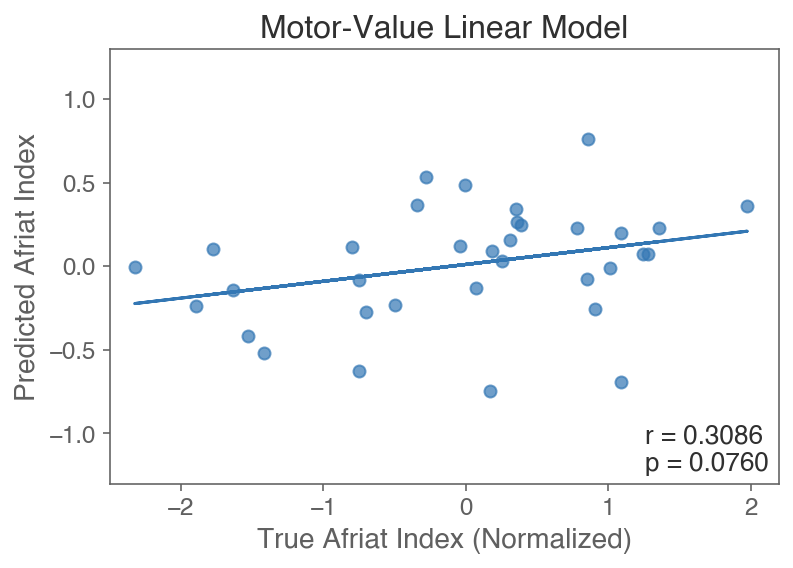

In [53]:
# Motor-value linear regression
coef_df_value_motor, mv_y_hats, mv_y_true, models = linear_models(motor_value_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Motor-Value Linear')
motor_linear_avg, motor_linear_score = average_coefs(coef_df_value_motor)
print(f'MSE: {motor_linear_score:.3f}')
# motor_linear_avg[-5:]

Fold: 1/34, Time: 15:24:10 04/17/22
Fold: 2/34, Time: 15:30:28 04/17/22
Fold: 3/34, Time: 15:36:29 04/17/22
Fold: 4/34, Time: 15:42:25 04/17/22
Fold: 5/34, Time: 15:48:20 04/17/22
Fold: 6/34, Time: 15:54:16 04/17/22
Fold: 7/34, Time: 16:00:12 04/17/22
Fold: 8/34, Time: 16:06:12 04/17/22
Fold: 9/34, Time: 16:12:07 04/17/22
Fold: 10/34, Time: 16:18:04 04/17/22
Fold: 11/34, Time: 16:24:00 04/17/22
Fold: 12/34, Time: 16:29:56 04/17/22
Fold: 13/34, Time: 16:35:52 04/17/22
Fold: 14/34, Time: 16:41:48 04/17/22
Fold: 15/34, Time: 16:47:43 04/17/22
Fold: 16/34, Time: 16:53:40 04/17/22
Fold: 17/34, Time: 16:59:36 04/17/22
Fold: 18/34, Time: 17:05:32 04/17/22
Fold: 19/34, Time: 17:11:30 04/17/22
Fold: 20/34, Time: 17:17:26 04/17/22
Fold: 21/34, Time: 17:23:23 04/17/22
Fold: 22/34, Time: 17:29:19 04/17/22
Fold: 23/34, Time: 17:35:16 04/17/22
Fold: 24/34, Time: 17:41:12 04/17/22
Fold: 25/34, Time: 17:47:07 04/17/22
Fold: 26/34, Time: 17:53:03 04/17/22
Fold: 27/34, Time: 17:59:00 04/17/22
Fold: 28/3

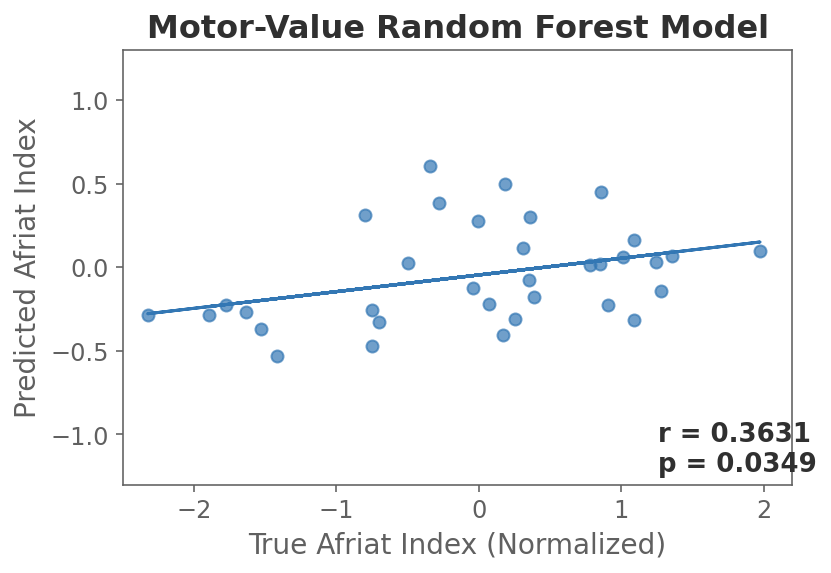

In [185]:
# Motor-value Random Forest
coef_df_value_motor, mv_y_hats, mv_y_true, models = random_forest_model(motor_value_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest', k_cv=33, feature_number=45)
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Motor-Value Random Forest')
motor_avg_forest, motor_forest_score = average_coefs(coef_df_value_motor)
print(f'MSE: {motor_forest_score:.3f}')
# motor_avg_forest[-5:]

## Load results and plot

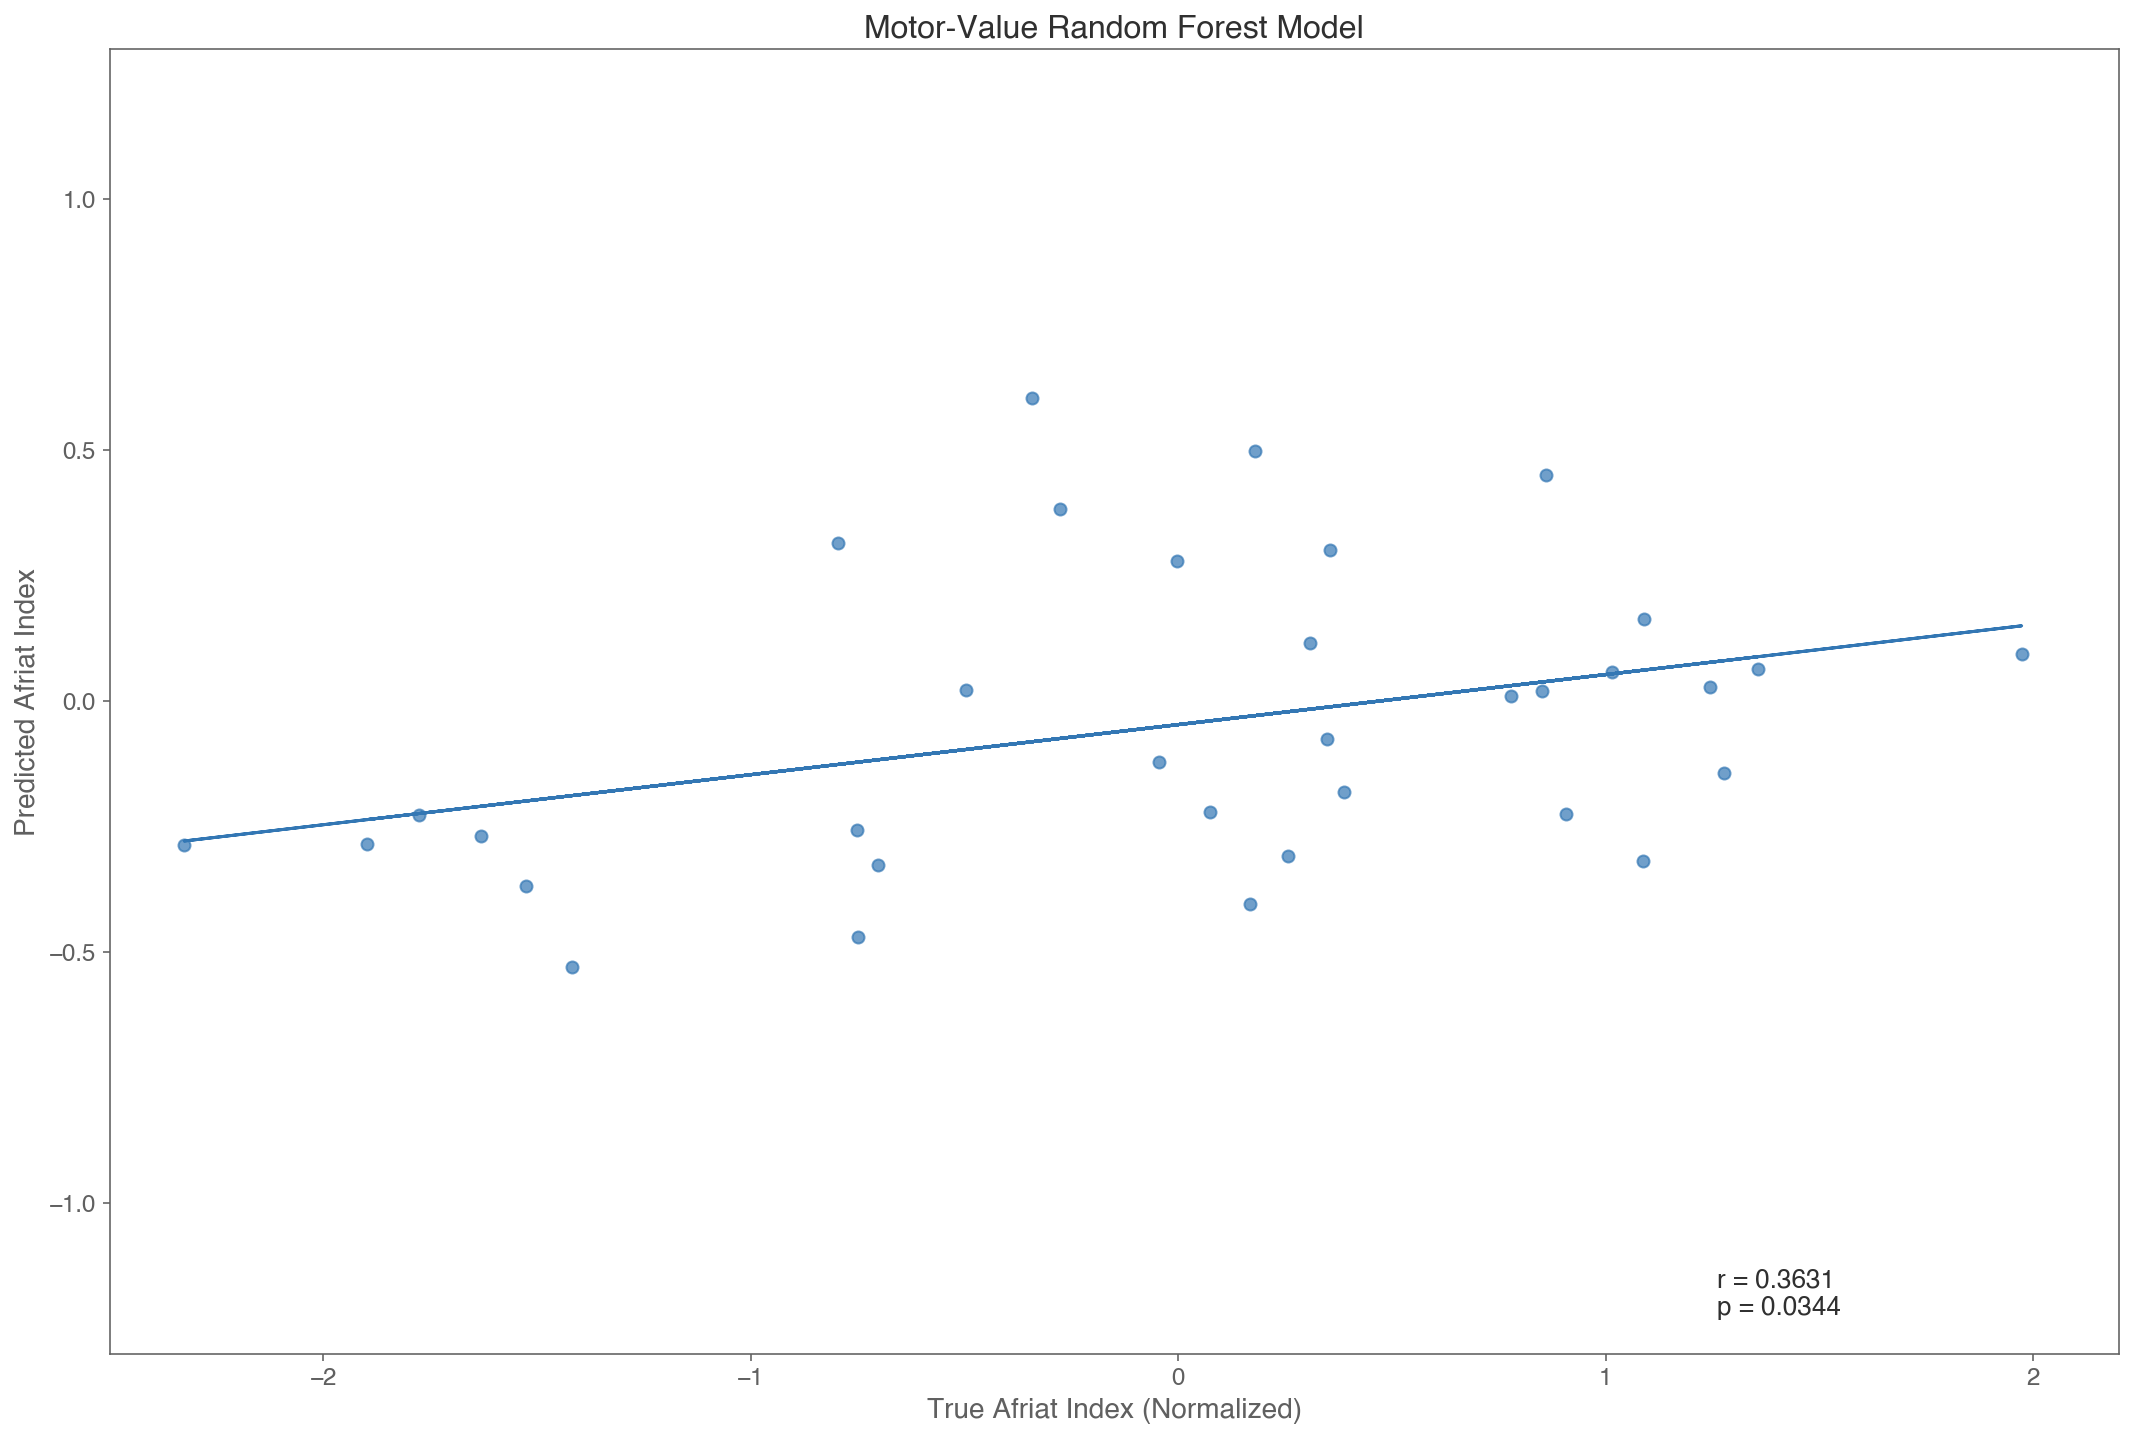

In [69]:
mv_rf_results = pd.read_csv('../data/mv_rf_results.csv')
mv_y_hats = mv_rf_results['Predicted']
mv_y_true = mv_rf_results['True']
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, model='Motor-Value Random Forest', save_path='../figures/test.png')

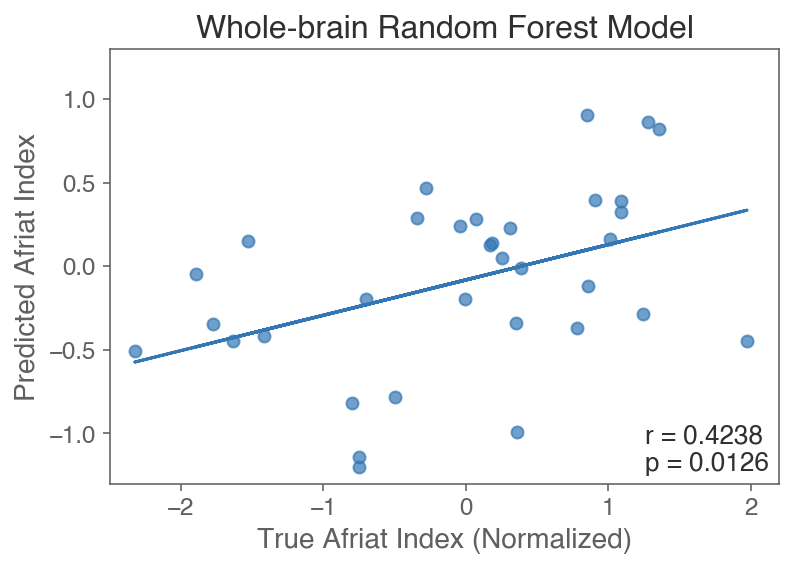

In [50]:
sch_rf_results = pd.read_csv('../data/sch_rf_results.csv')
sch_y_hats = sch_rf_results['Predicted']
sch_y_true = sch_rf_results['True']
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')

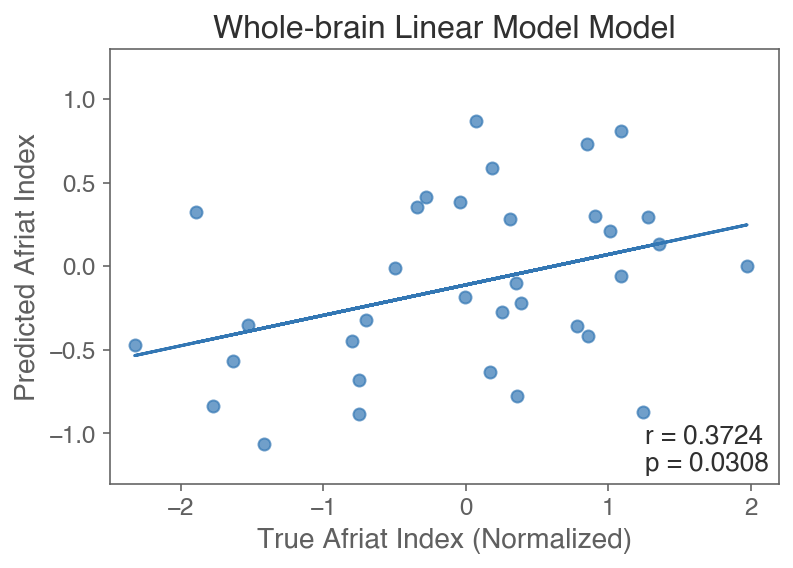

In [54]:
sch_linear_results = pd.read_csv('../data/sch_linear_results.csv')
sch_y_hats = sch_linear_results['Predicted']
sch_y_true = sch_linear_results['True']
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Linear Model')

In [60]:
mv_coef = pd.read_csv('../data/mv_rf_coef.csv')
mv_coef.sort_values(['Count', 'Beta'])

,Unnamed: 0,Feature,Beta,Count
0,0,dACC__SMA_L,0.006908,29.0
1,1,SMA_L__VSTR,0.007039,31.0
3,3,dACC__VMPFC,0.008332,32.0
2,2,preSMA_L__SMA_L,0.008891,32.0
4,4,preSMA_L__VSTR,0.011924,32.0
5,5,preSMA_R__SMA_R,0.012665,32.0
14,14,preSMA_R__M1_L,0.007771,33.0
10,10,preSMA_R__VMPFC,0.008272,33.0
6,6,preSMA_L__SMA_R,0.009265,33.0
8,8,SMA_R__M1_L,0.009866,33.0


In [58]:
sch_linear_coef = pd.read_csv('../data/sch_linear_coef.csv')
sch_linear_coef

,Unnamed: 0,Feature,Beta,Count
0,0,LH_Default_PFC_7__LH_Default_PFC_5,-0.001023,1.0
1,1,RH_Vis_1__LH_Limbic_OFC_1,-0.002685,1.0
2,2,LH_Default_PFC_6__LH_Default_PFC_4,-0.000060,1.0
3,3,RH_SomMot_2__LH_Default_PFC_3,0.003185,1.0
4,4,RH_Cont_Par_2__LH_Cont_Par_1,0.001517,1.0
...,...,...,...,...
56,56,RH_Default_Temp_3__LH_SalVentAttn_Med_3,-0.078728,16.0
57,57,RH_DorsAttn_Post_5__LH_Limbic_TempPole_1,0.074795,20.0
58,58,RH_Default_PFCv_1__RH_Cont_Par_1,0.155634,25.0
59,59,LH_Default_pCunPCC_1__LH_SomMot_6,0.293478,27.0


In [64]:
sch_rf_coef = pd.read_csv('../data/sch_rf_coef.csv')
sch_rf_coef.sort_values(['Count', 'Beta']).tail(20)

,Unnamed: 0,Feature,Beta,Count
130,130,RH_Default_pCunPCC_1__LH_SomMot_6,0.010526,23.0
127,127,RH_SomMot_2__LH_Default_pCunPCC_1,0.084088,23.0
132,132,RH_DorsAttn_Post_5__LH_Limbic_TempPole_1,0.027199,24.0
133,133,RH_Default_PFCdPFCm_3__LH_Cont_Par_1,0.012049,25.0
134,134,LH_Default_PFC_6__LH_Default_PFC_1,0.006008,26.0
135,135,RH_Default_PFCv_2__RH_Vis_1,0.011227,27.0
136,136,RH_Default_PFCv_1__RH_Cont_Par_1,0.039896,27.0
140,140,LH_Default_PFC_7__LH_Limbic_TempPole_2,0.003541,28.0
137,137,RH_DorsAttn_FEF_1__LH_SalVentAttn_ParOper_1,0.004062,28.0
139,139,LH_Default_PFC_6__LH_Limbic_TempPole_1,0.009509,28.0


In [55]:
from statsmodels.stats.multitest import fdrcorrection
fdrcorrection([0.0352, 0.0302, 0.0126, 0.0760])

(array([ True,  True,  True, False]),
 array([0.04693333, 0.04693333, 0.04693333, 0.076     ]))

## Whole-brain Matrix

MSE: 0.981


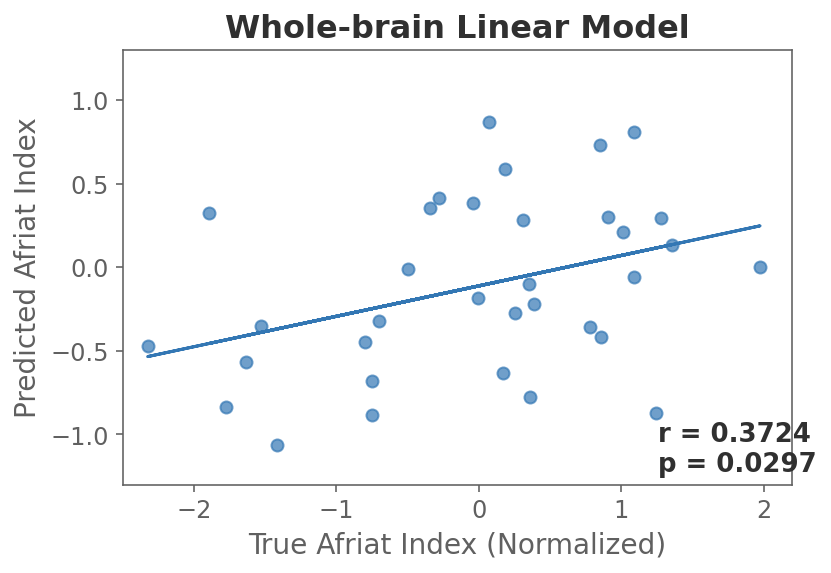

In [82]:
# Schaefer linear regression
coef_df_schaefer, sch_y_hats, sch_y_true, sch_lin_models = linear_models(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Linear')
sch_avg_linear, sch_linear_score = average_coefs(coef_df_schaefer)
print(f'MSE: {sch_linear_score:.3f}')
# draw_glassbrain(sch_avg_linear[-5:].reset_index(drop=True))

In [84]:
sch_avg_linear

,Feature,Beta,Count
0,LH_Default_PFC_7__LH_Default_PFC_5,-0.001023,1.0
1,RH_Vis_1__LH_Limbic_OFC_1,-0.002685,1.0
2,LH_Default_PFC_6__LH_Default_PFC_4,-0.000060,1.0
3,RH_SomMot_2__LH_Default_PFC_3,0.003185,1.0
4,RH_Cont_Par_2__LH_Cont_Par_1,0.001517,1.0
...,...,...,...
56,RH_Default_Temp_3__LH_SalVentAttn_Med_3,-0.078728,16.0
57,RH_DorsAttn_Post_5__LH_Limbic_TempPole_1,0.074795,20.0
58,RH_Default_PFCv_1__RH_Cont_Par_1,0.155634,25.0
59,LH_Default_pCunPCC_1__LH_SomMot_6,0.293478,27.0


Fold: 1/34, Time: 13:45:01 04/19/22
Fold: 2/34, Time: 13:53:31 04/19/22
Fold: 3/34, Time: 14:02:01 04/19/22
Fold: 4/34, Time: 14:10:41 04/19/22
Fold: 5/34, Time: 14:19:14 04/19/22
Fold: 6/34, Time: 14:27:44 04/19/22
Fold: 7/34, Time: 14:36:16 04/19/22
Fold: 8/34, Time: 14:44:52 04/19/22
Fold: 9/34, Time: 14:53:21 04/19/22
Fold: 10/34, Time: 15:01:53 04/19/22
Fold: 11/34, Time: 15:10:24 04/19/22
Fold: 12/34, Time: 15:18:54 04/19/22
Fold: 13/34, Time: 15:27:23 04/19/22
Fold: 14/34, Time: 15:35:58 04/19/22
Fold: 15/34, Time: 15:44:30 04/19/22
Fold: 16/34, Time: 15:53:05 04/19/22
Fold: 17/34, Time: 16:01:39 04/19/22
Fold: 18/34, Time: 16:10:05 04/19/22
Fold: 19/34, Time: 16:18:38 04/19/22
Fold: 20/34, Time: 16:27:22 04/19/22
Fold: 21/34, Time: 16:35:58 04/19/22
Fold: 22/34, Time: 16:44:33 04/19/22
Fold: 23/34, Time: 16:53:14 04/19/22
Fold: 24/34, Time: 17:02:06 04/19/22
Fold: 25/34, Time: 17:10:41 04/19/22
Fold: 26/34, Time: 17:19:13 04/19/22
Fold: 27/34, Time: 17:27:46 04/19/22
Fold: 28/3

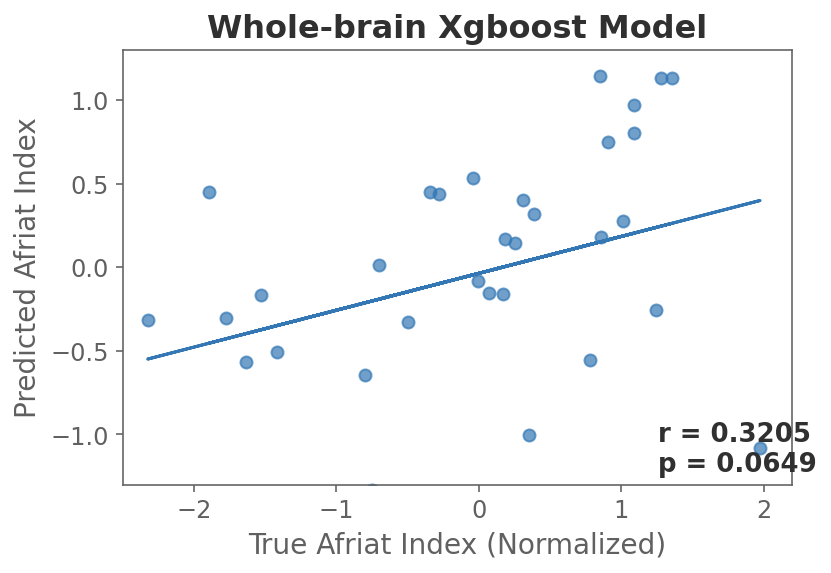

In [187]:
# Schaefer XGBoost with Hyperparameter
xg_coef_df_schaefer, xg_sch_y_hats, xg_sch_y_true, xg_models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Xgboost', k_cv=33, feature_number=45)
r, pval = print_results(xg_sch_y_true, xg_sch_y_hats, inconsistency_measure, 'Whole-brain Xgboost')
xg_avg_forest, xg_forest_score = average_coefs(xg_coef_df_schaefer)
print(f'MSE: {xg_forest_score:.3f}')

Fold: 1/34, Time: 10:21:49 04/19/22
Fold: 2/34, Time: 10:27:52 04/19/22
Fold: 3/34, Time: 10:33:48 04/19/22
Fold: 4/34, Time: 10:39:47 04/19/22
Fold: 5/34, Time: 10:45:44 04/19/22
Fold: 6/34, Time: 10:51:40 04/19/22
Fold: 7/34, Time: 10:57:37 04/19/22
Fold: 8/34, Time: 11:03:33 04/19/22
Fold: 9/34, Time: 11:09:31 04/19/22
Fold: 10/34, Time: 11:15:29 04/19/22
Fold: 11/34, Time: 11:21:26 04/19/22
Fold: 12/34, Time: 11:27:24 04/19/22
Fold: 13/34, Time: 11:33:21 04/19/22
Fold: 14/34, Time: 11:39:18 04/19/22
Fold: 15/34, Time: 11:45:15 04/19/22
Fold: 16/34, Time: 11:51:12 04/19/22
Fold: 17/34, Time: 11:57:10 04/19/22
Fold: 18/34, Time: 12:03:07 04/19/22
Fold: 19/34, Time: 12:09:04 04/19/22
Fold: 20/34, Time: 12:15:04 04/19/22
Fold: 21/34, Time: 12:21:01 04/19/22
Fold: 22/34, Time: 12:26:59 04/19/22
Fold: 23/34, Time: 12:32:55 04/19/22
Fold: 24/34, Time: 12:38:54 04/19/22
Fold: 25/34, Time: 12:44:52 04/19/22
Fold: 26/34, Time: 12:50:53 04/19/22
Fold: 27/34, Time: 12:56:50 04/19/22
Fold: 28/3

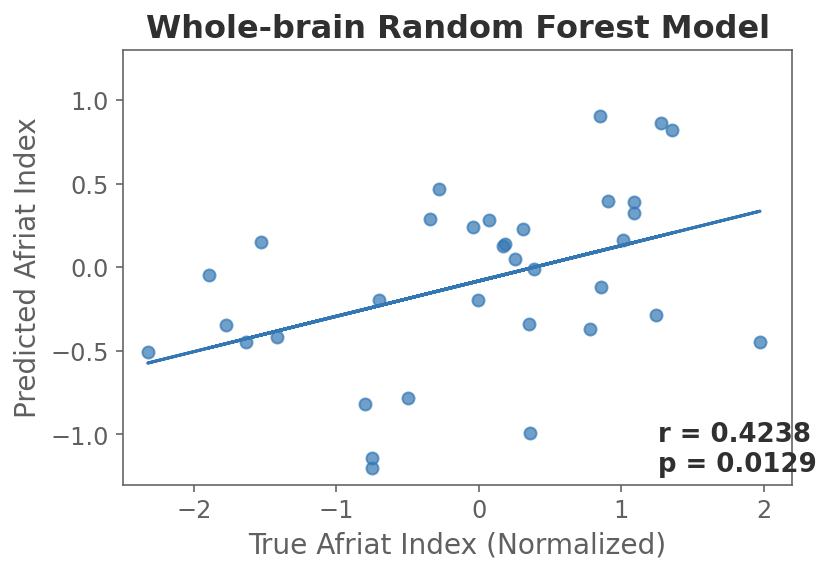

In [186]:
# Schaefer Random Forest with Hyperparameter
rf_coef_df_schaefer, rf_sch_y_hats, rf_sch_y_true, models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest', k_cv=33, feature_number=45)
r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
sch_avg_forest, sch_forest_score = average_coefs(rf_coef_df_schaefer)
print(f'MSE: {sch_forest_score:.3f}')

In [ ]:
# Schaefer Random Forest with Hyperparameter
rf_coef_df_schaefer, rf_sch_y_hats, rf_sch_y_true, models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest', k_cv=33, feature_number=45)
r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
sch_avg_forest, sch_forest_score = average_coefs(rf_coef_df_schaefer)
print(f'MSE: {sch_forest_score:.3f}')

----    Iter 1/33   ----
Fold: 1/33, Time: 14:44:57 04/06/22
Fold: 2/33, Time: 14:50:47 04/06/22
Fold: 3/33, Time: 14:56:33 04/06/22
Fold: 4/33, Time: 15:02:18 04/06/22
Fold: 5/33, Time: 15:08:03 04/06/22
Fold: 6/33, Time: 15:13:48 04/06/22
Fold: 7/33, Time: 15:19:36 04/06/22
Fold: 8/33, Time: 15:25:21 04/06/22
Fold: 9/33, Time: 15:31:07 04/06/22
Fold: 10/33, Time: 15:36:52 04/06/22
Fold: 11/33, Time: 15:42:39 04/06/22
Fold: 12/33, Time: 15:48:26 04/06/22
Fold: 13/33, Time: 15:54:15 04/06/22
Fold: 14/33, Time: 16:00:00 04/06/22
Fold: 15/33, Time: 16:05:46 04/06/22
Fold: 16/33, Time: 16:11:31 04/06/22
Fold: 17/33, Time: 16:17:16 04/06/22
Fold: 18/33, Time: 16:23:02 04/06/22
Fold: 19/33, Time: 16:28:49 04/06/22
Fold: 20/33, Time: 16:34:35 04/06/22
Fold: 21/33, Time: 16:40:21 04/06/22
Fold: 22/33, Time: 16:46:08 04/06/22
Fold: 23/33, Time: 16:51:56 04/06/22
Fold: 24/33, Time: 16:57:42 04/06/22
Fold: 25/33, Time: 17:03:28 04/06/22
Fold: 26/33, Time: 17:09:13 04/06/22
Fold: 27/33, Time: 17:

C:\Users\Asaf\AppData\Local\Temp/ipykernel_26608/706594188.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (6, 4))


----    Iter 22/33   ----
Fold: 1/33, Time: 09:38:08 04/09/22
Fold: 2/33, Time: 09:43:55 04/09/22
Fold: 3/33, Time: 09:49:41 04/09/22
Fold: 4/33, Time: 09:55:27 04/09/22
Fold: 5/33, Time: 10:01:14 04/09/22
Fold: 6/33, Time: 10:07:00 04/09/22
Fold: 7/33, Time: 10:12:46 04/09/22
Fold: 8/33, Time: 10:18:32 04/09/22
Fold: 9/33, Time: 10:24:19 04/09/22
Fold: 10/33, Time: 10:30:04 04/09/22
Fold: 11/33, Time: 10:35:50 04/09/22
Fold: 12/33, Time: 10:41:37 04/09/22
Fold: 13/33, Time: 10:47:24 04/09/22
Fold: 14/33, Time: 10:53:11 04/09/22
Fold: 15/33, Time: 10:58:57 04/09/22
Fold: 16/33, Time: 11:04:43 04/09/22
Fold: 17/33, Time: 11:10:28 04/09/22
Fold: 18/33, Time: 11:16:14 04/09/22
Fold: 19/33, Time: 11:21:59 04/09/22
Fold: 20/33, Time: 11:27:46 04/09/22
Fold: 21/33, Time: 11:33:32 04/09/22
Fold: 22/33, Time: 11:39:17 04/09/22
Fold: 23/33, Time: 11:45:02 04/09/22
Fold: 24/33, Time: 11:50:49 04/09/22
Fold: 25/33, Time: 11:56:36 04/09/22
Fold: 26/33, Time: 12:02:22 04/09/22
Fold: 27/33, Time: 12

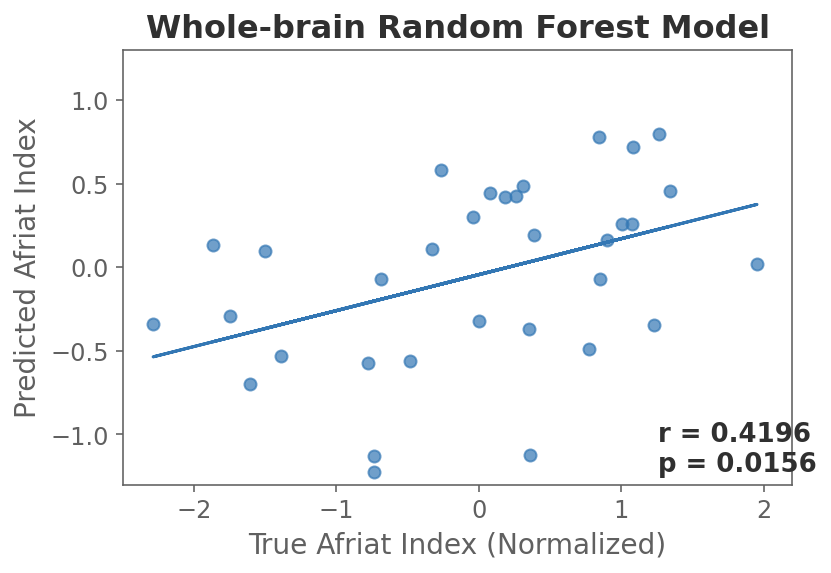

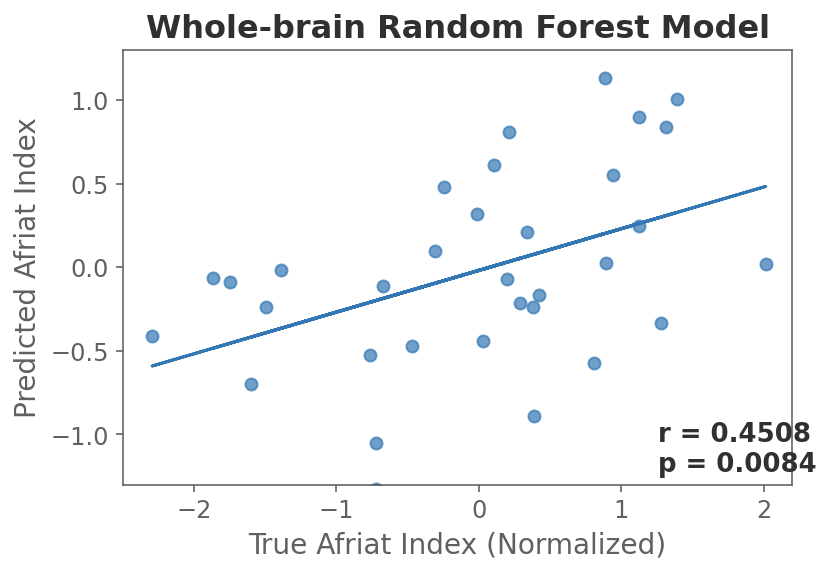

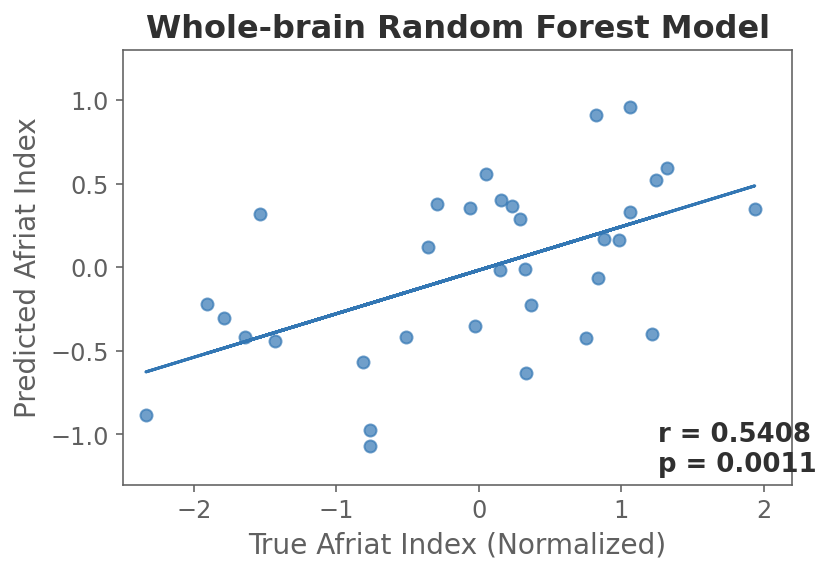

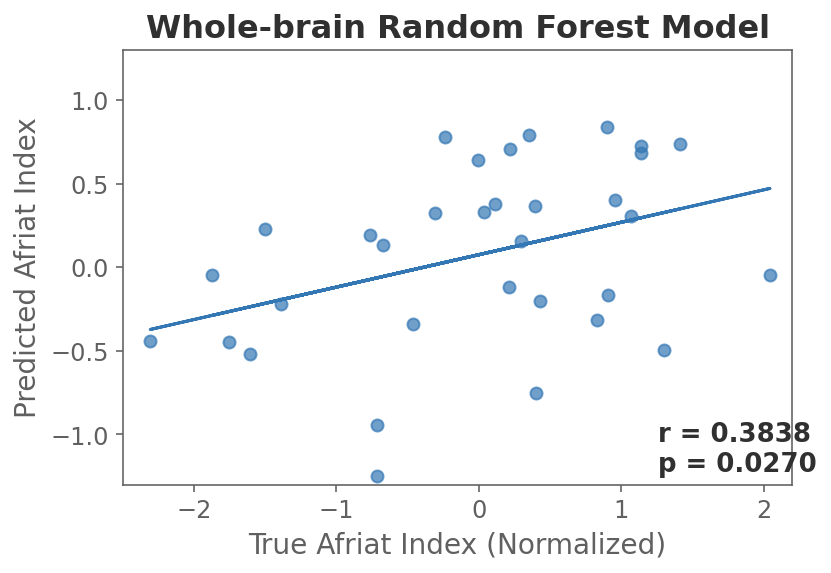

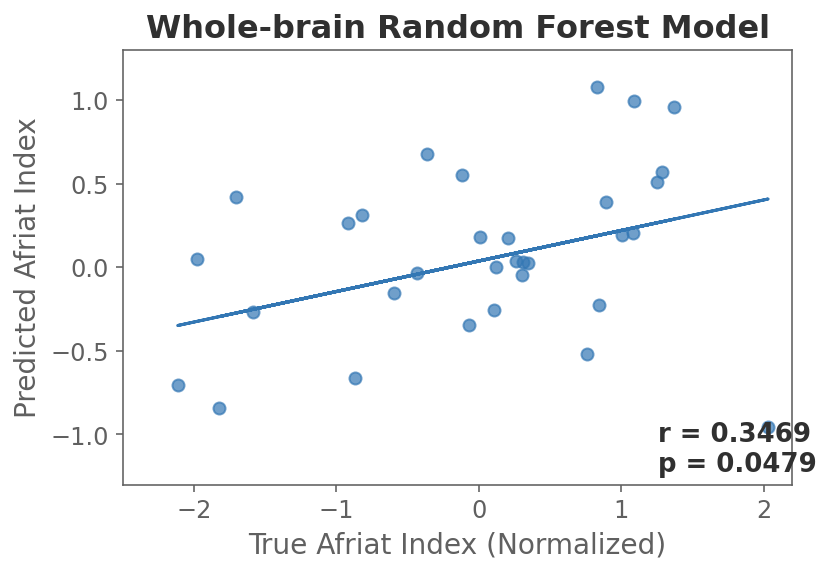

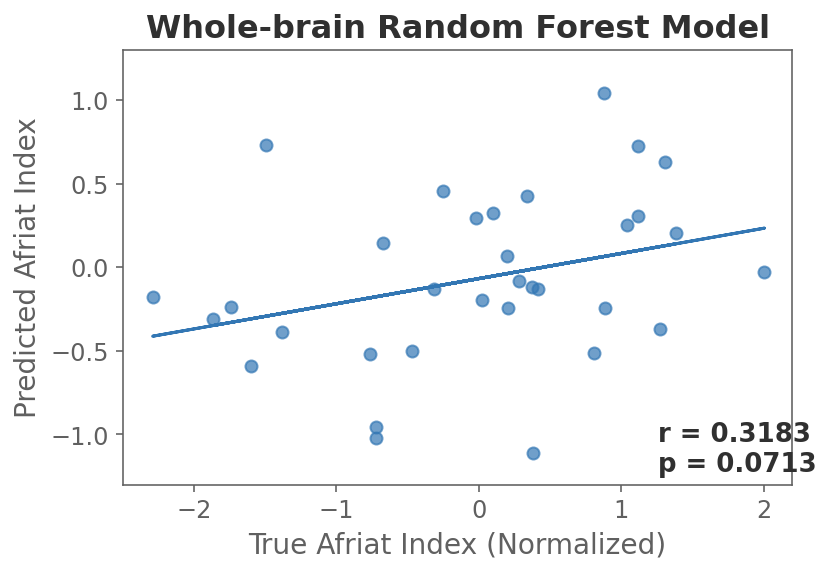

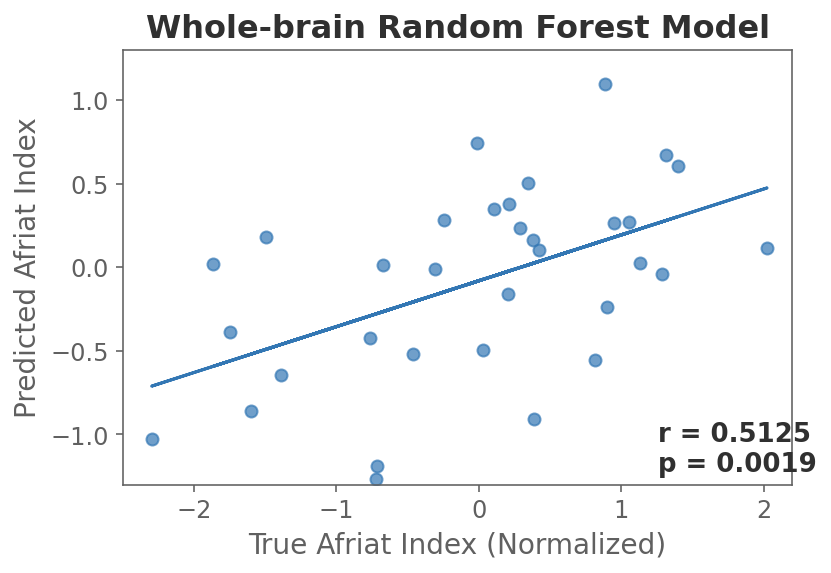

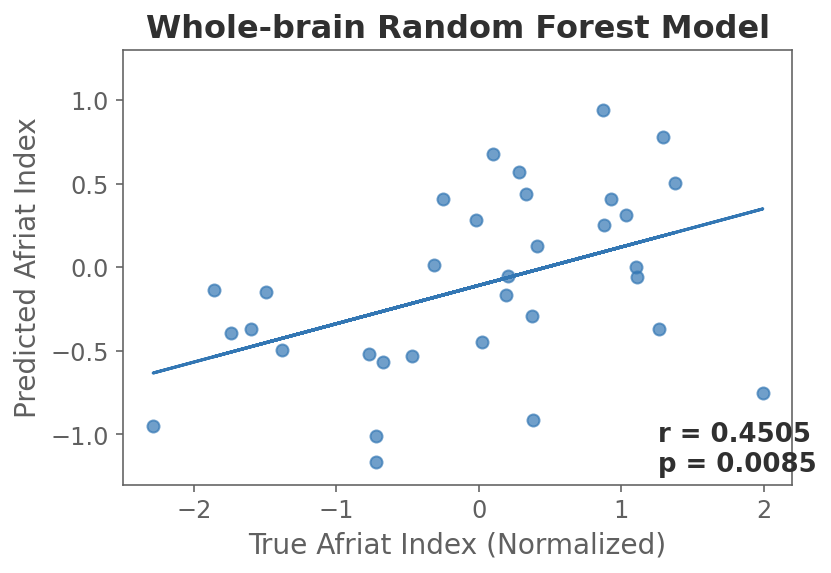

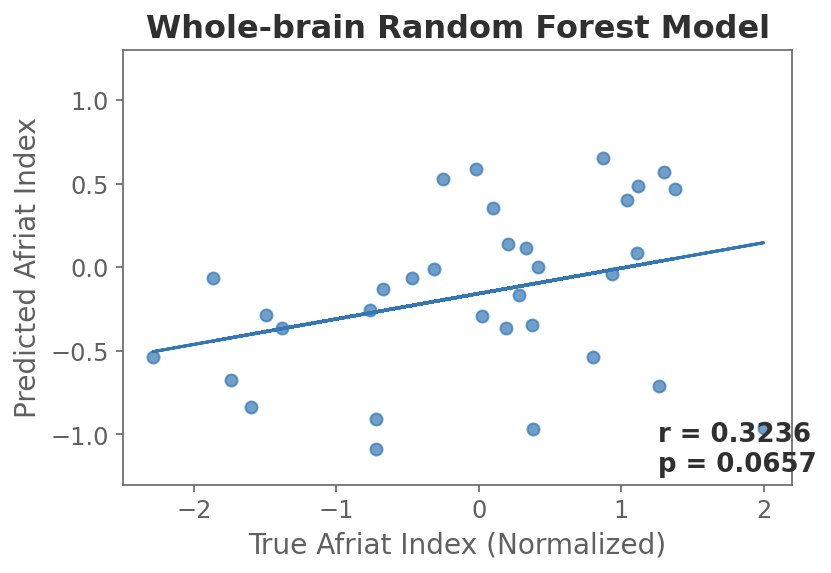

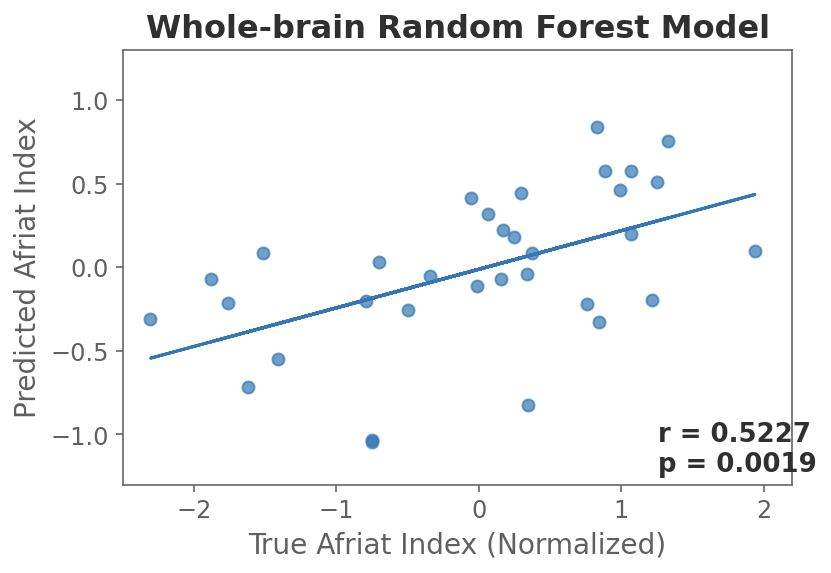

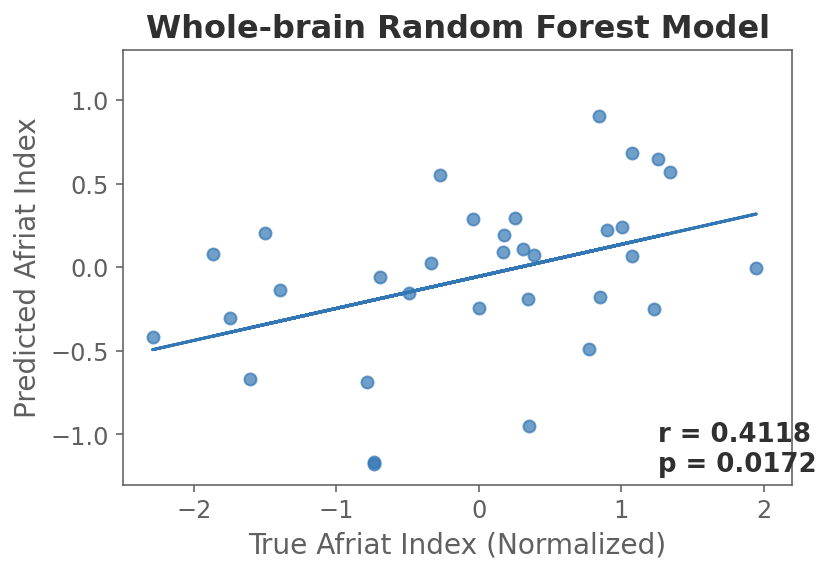

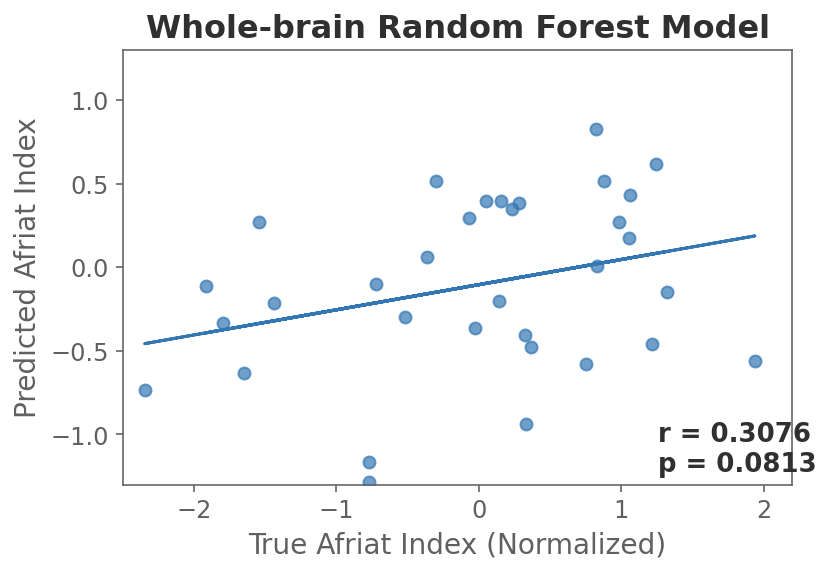

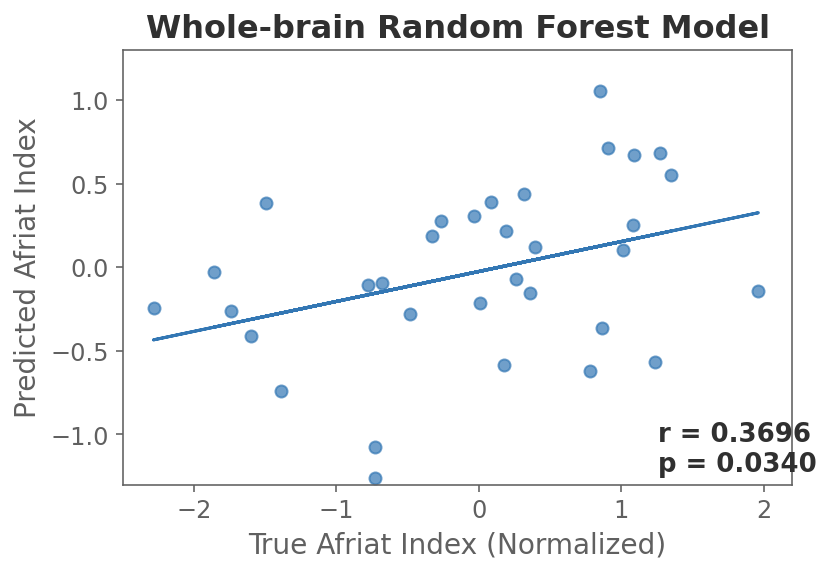

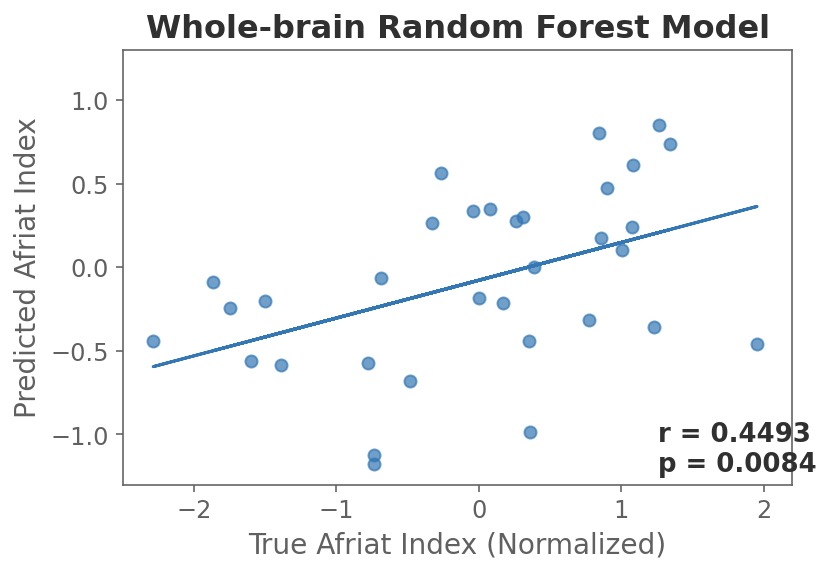

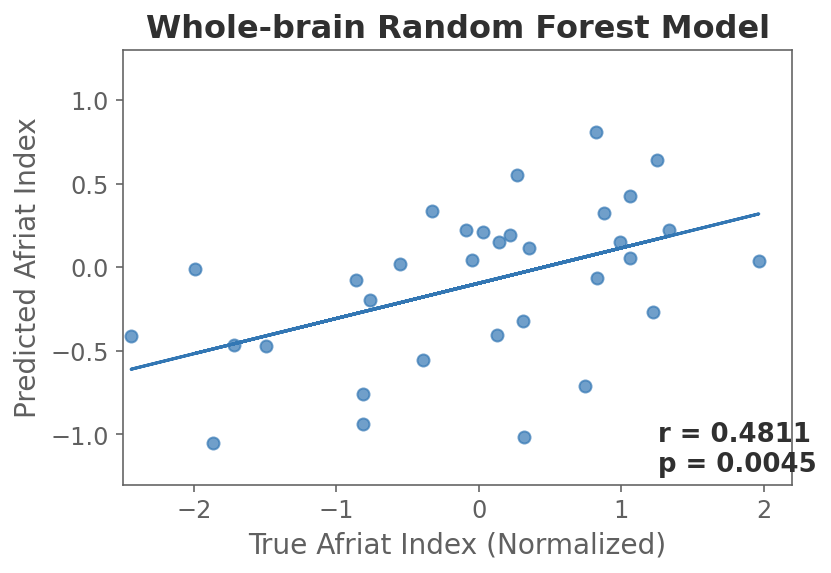

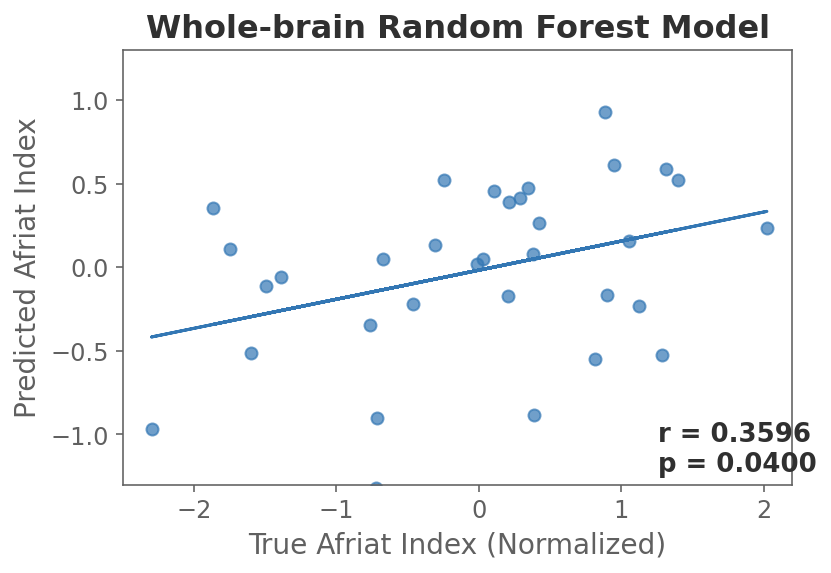

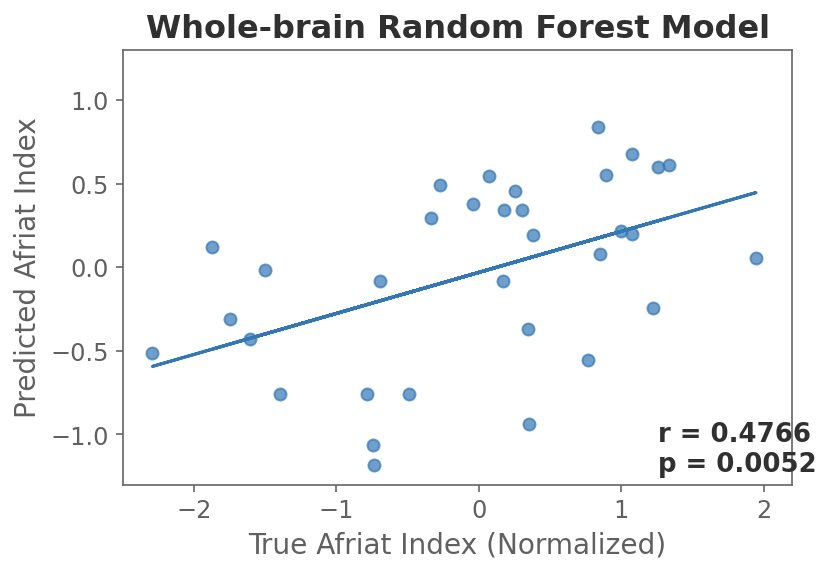

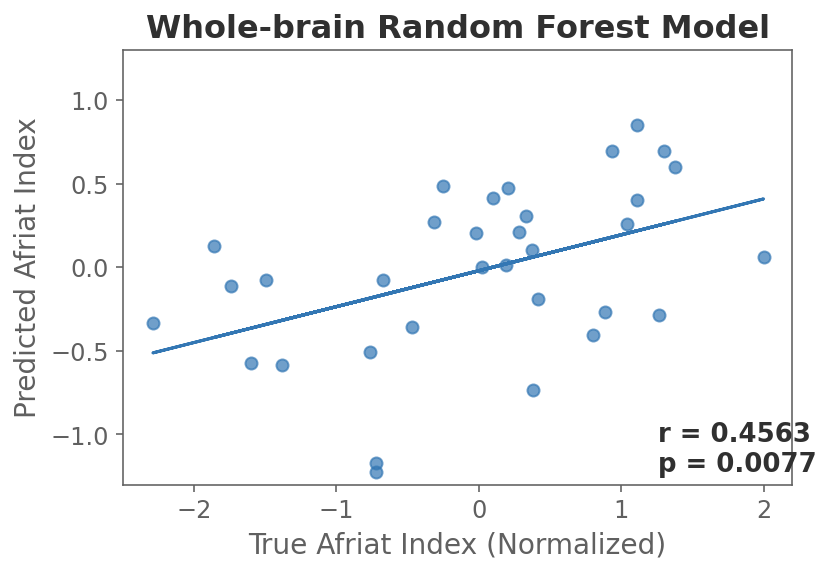

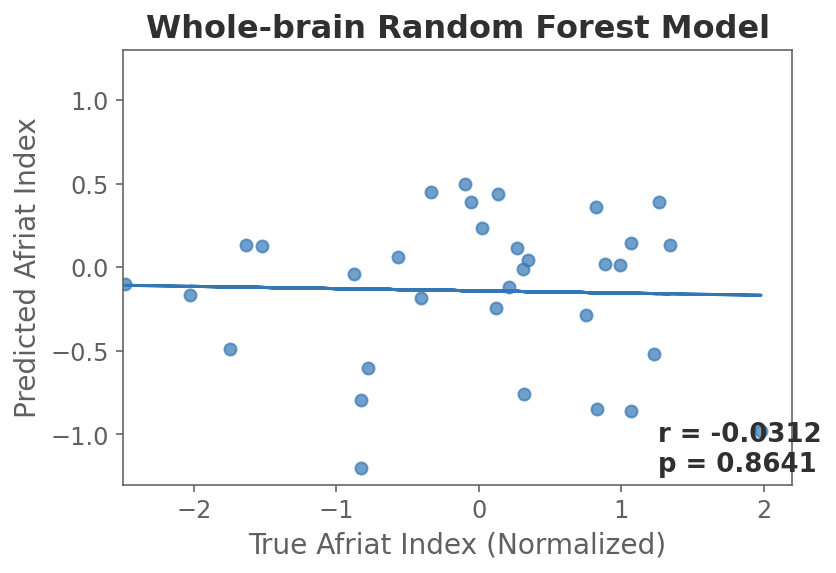

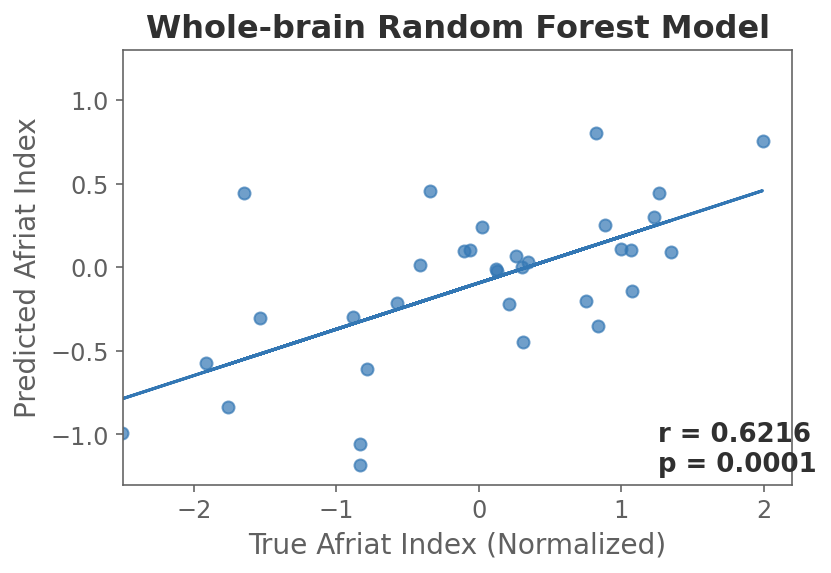

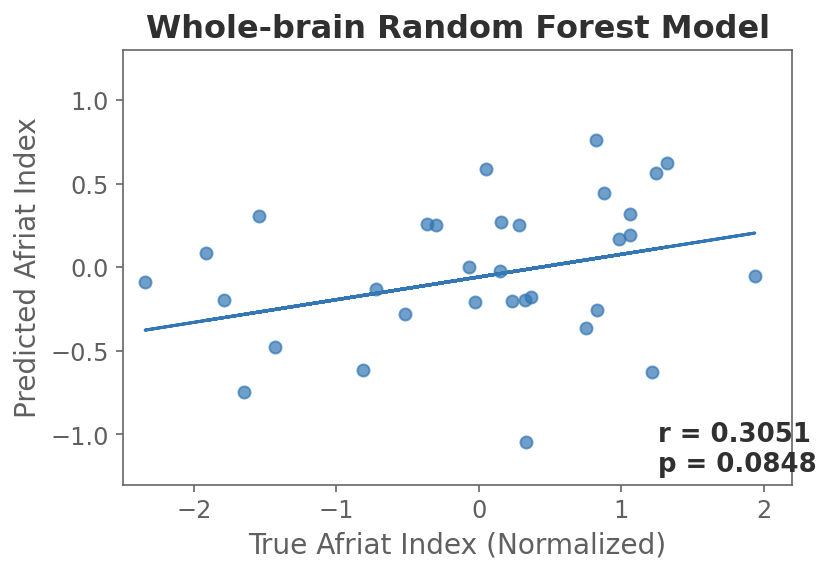

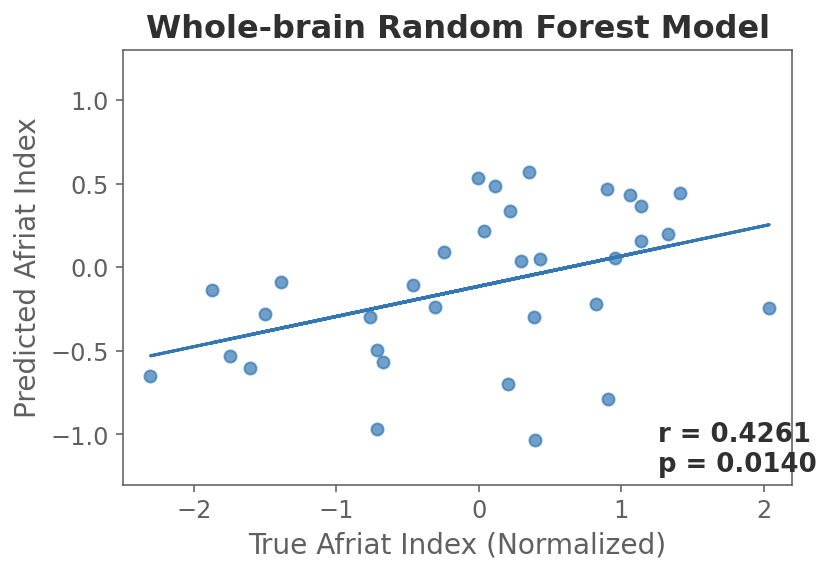

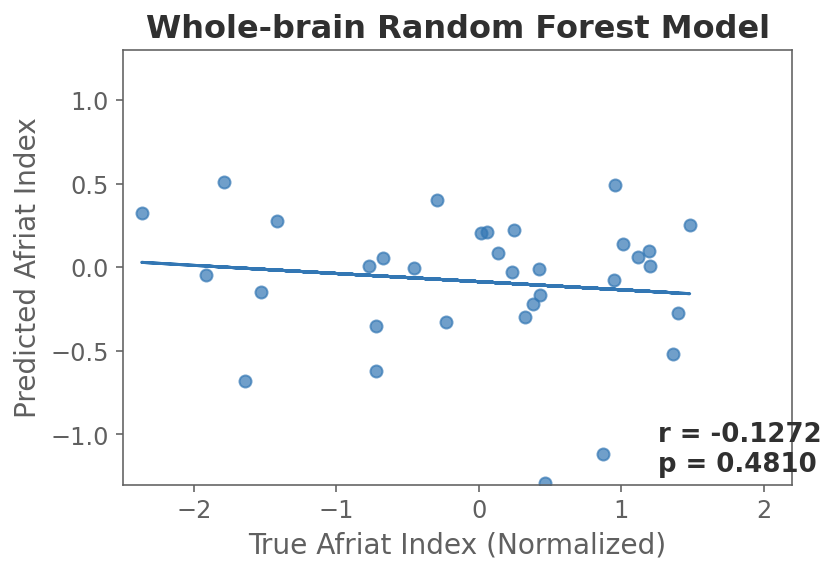

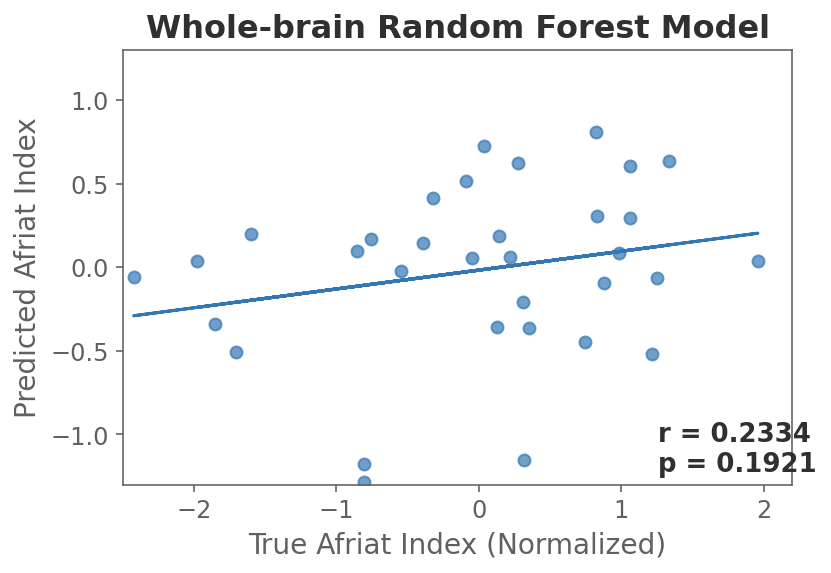

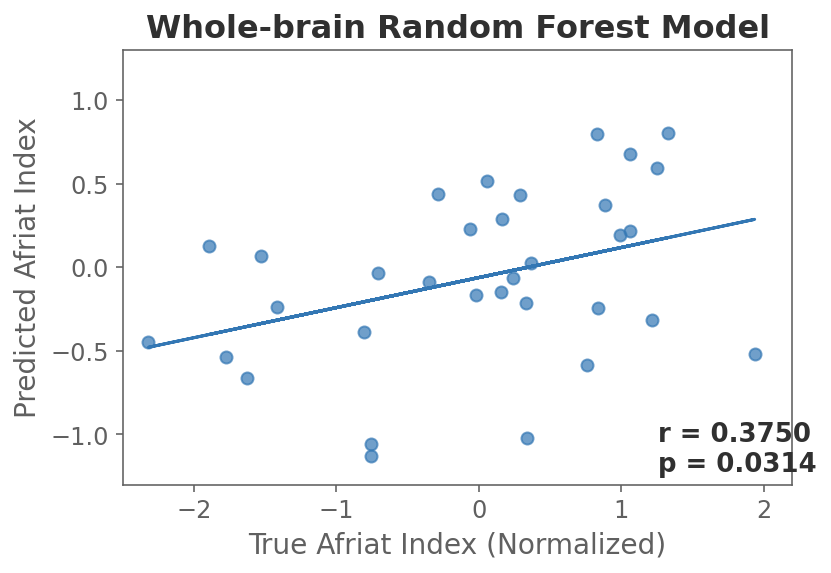

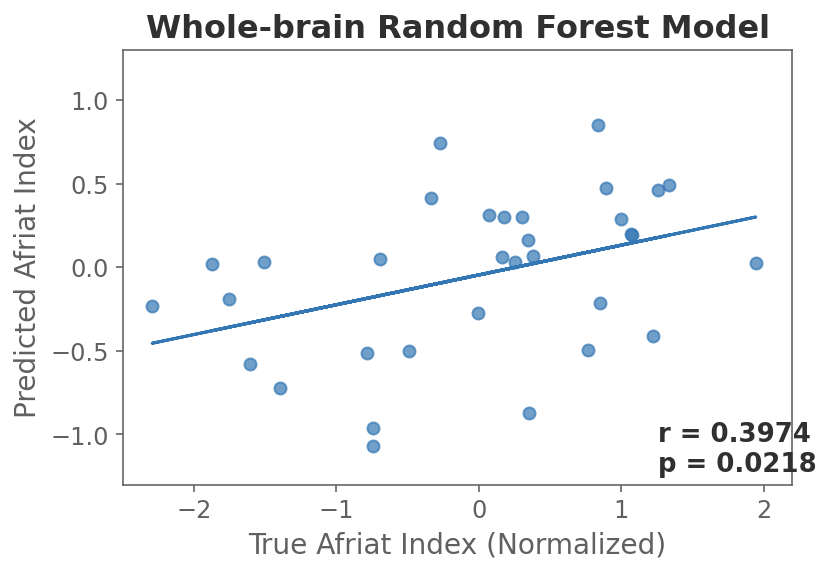

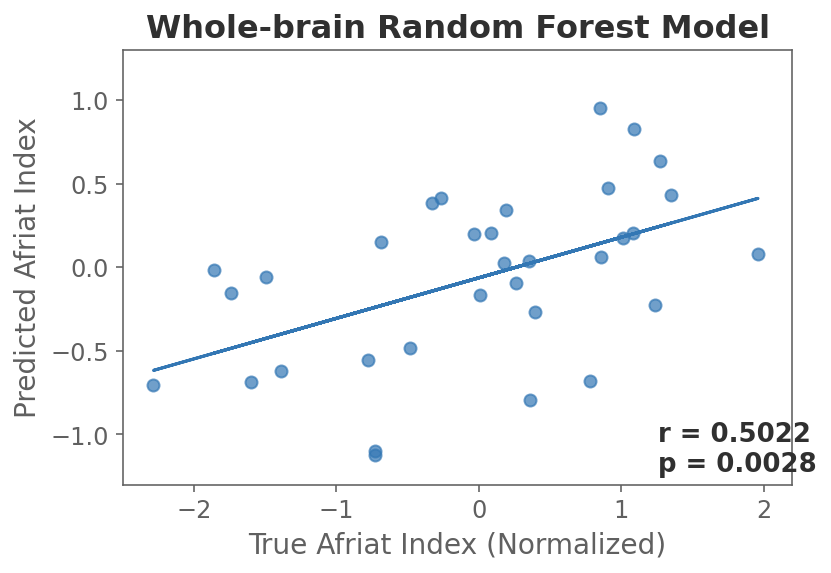

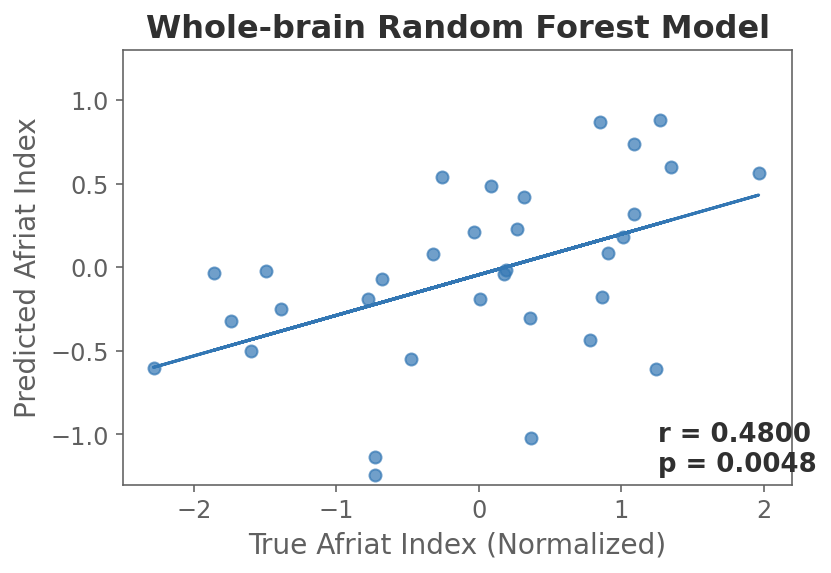

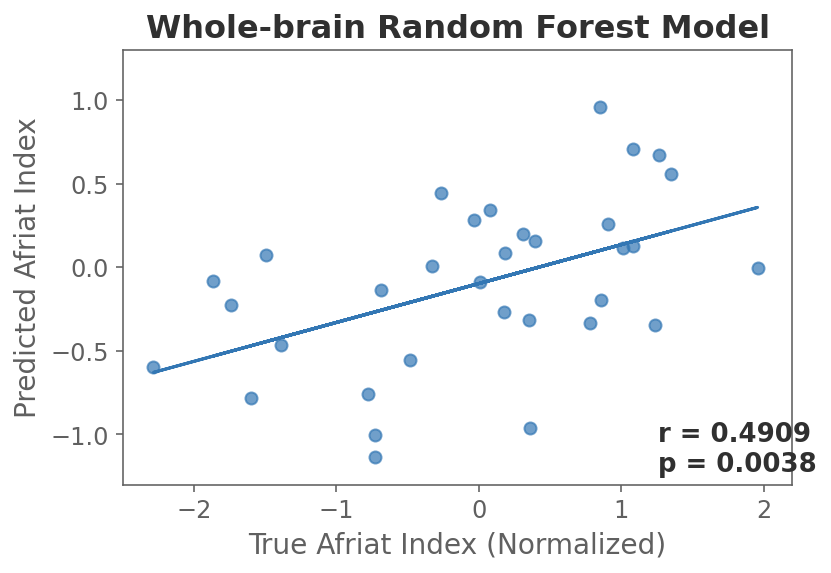

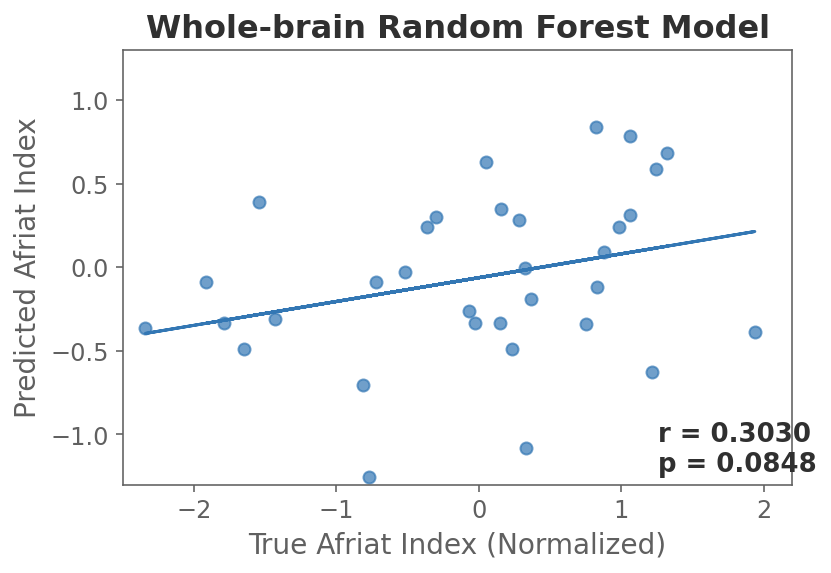

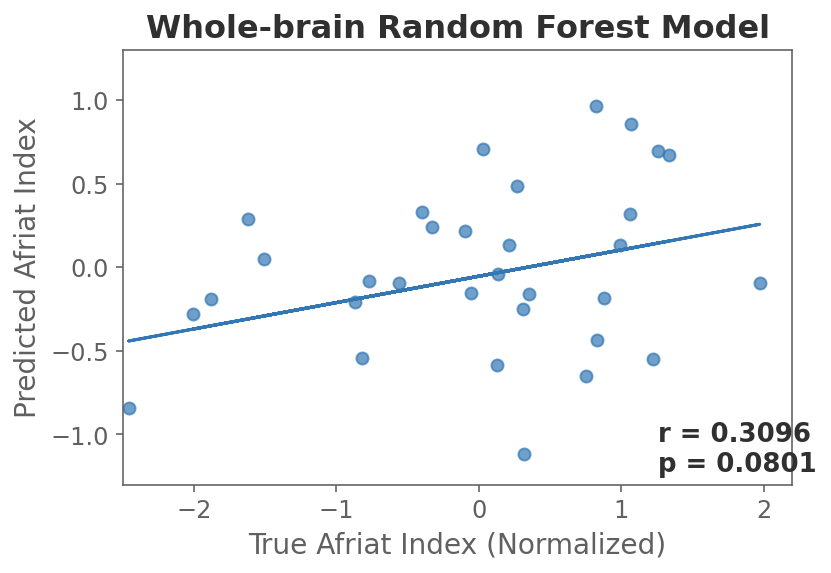

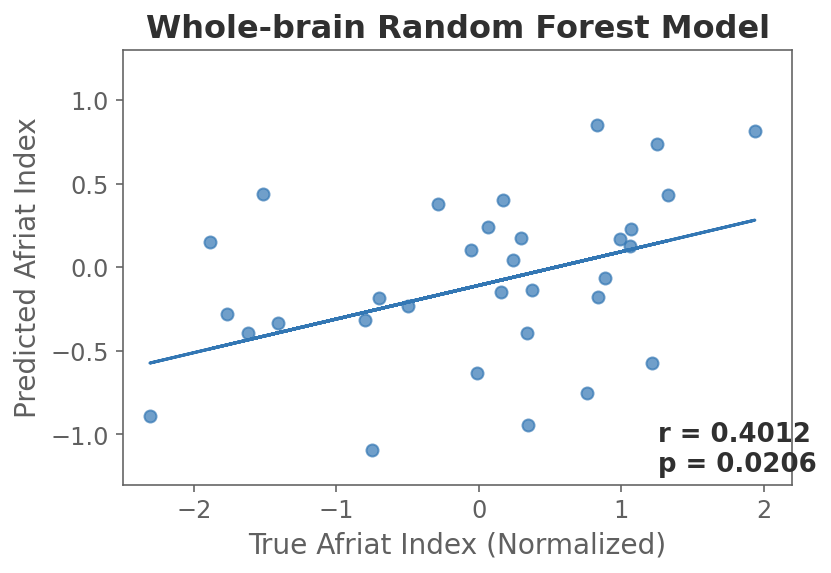

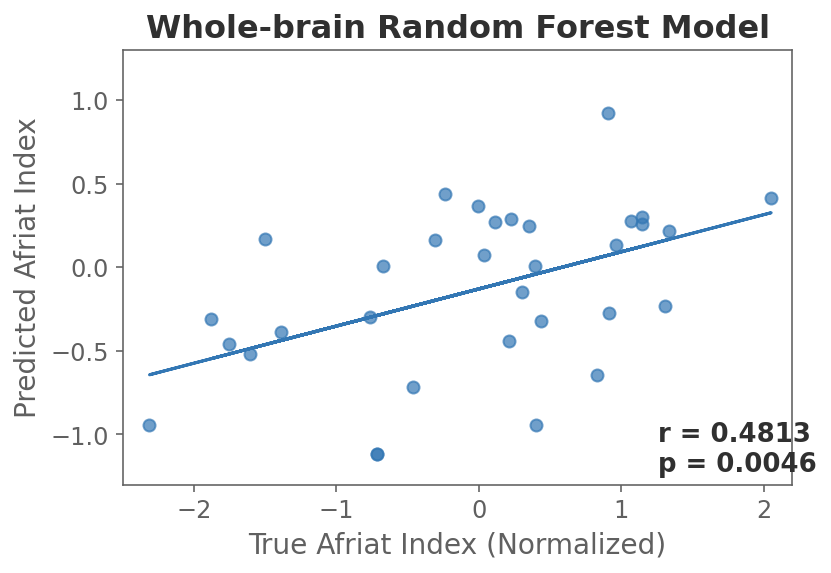

In [176]:
rs = []
pvals = []
for i in range(33):
    print(f'----    Iter {i+1}/33   ----')
    subjects_index = schaefer_mat.loc[inconsistent_subjects, :].index.to_list()
    subjects_index.pop(i)
    rf_coef_df_schaefer, rf_sch_y_hats, rf_sch_y_true, models = random_forest_model(schaefer_mat.loc[subjects_index, :], Ys_incon.loc[subjects_index], inconsistency_measure, 'RandomForest', k_cv=32, feature_number=45)
    r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
    rs.append(r), pvals.append(pval)

In [183]:
sum(np.array(pvals)<0.05), len(pvals)

(24, 33)

In [174]:
rs_no_selection = rs.copy()
pvals_no_selection = pvals.copy()

## Save Figures 

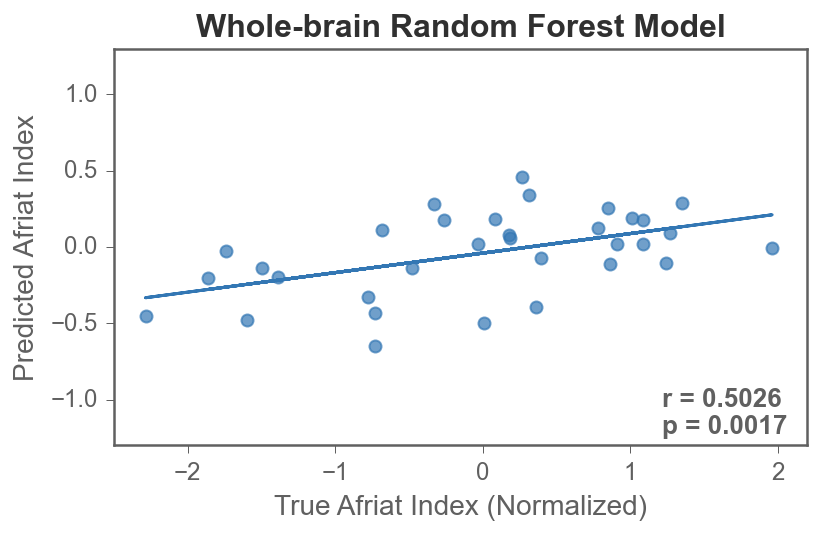

In [636]:
r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
plt.tight_layout()
plt.savefig('whole_brain_rf.svg', dpi = 600)

In [1]:
# motor value RF
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Value-Motor Random Forest')
plt.tight_layout()
# plt.savefig('mv_rf.svg', dpi = 600)

NameError: name 'print_results' is not defined

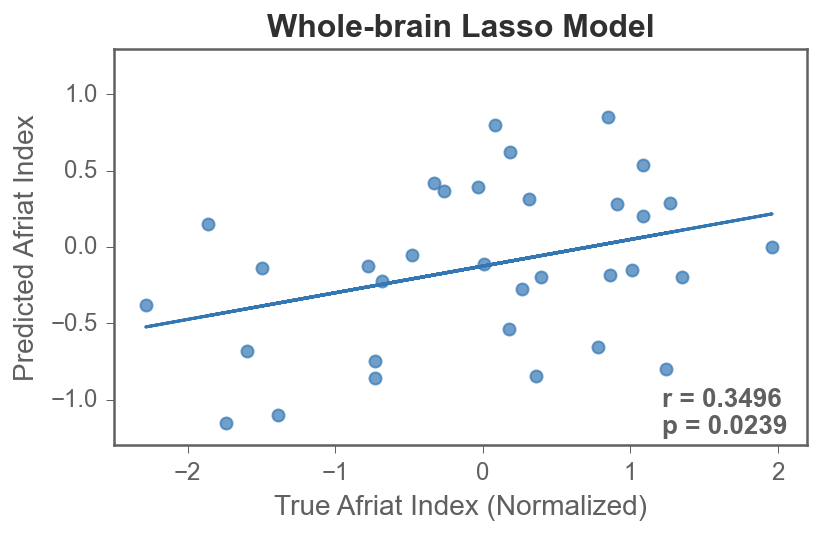

In [547]:
# whole brain lasso
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Lasso')
plt.tight_layout()
# plt.savefig('whole_brain_lasso.png', dpi = 600)

C:\Users\Asaf\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-3.57299522e-01 -2.19965074e+00 -2.19965115e+00 -3.57299522e-01
 -3.57299522e-01 -3.57299522e-01 -3.57299522e-01 -8.47230080e+56
             nan -2.19965074e+00 -2.19965074e+00 -2.47216879e+26
 -3.57299522e-01 -3.57299522e-01             nan -2.19965115e+00
 -2.19965115e+00             nan -3.57299522e-01 -2.19965115e+00
 -3.57299522e-01 -3.57299522e-01 -2.19965074e+00             nan
 -3.57299522e-01 -2.19965060e+00 -8.47230080e+56 -8.47230080e+56
 -8.47230080e+56             nan             nan -2.47216879e+26
 -2.19965115e+00 -5.10622475e+35             nan -3.63790312e+45
 -2.19965074e+00 -3.57299522e-01 -3.57299522e-01 -3.57299522e-01
 -2.19965115e+00 -5.10622475e+35 -2.19965060e+00 -2.19965115e+00
             nan -3.57299522e-01 -3.63790312e+45 -5.10622475e+35
 -2.19965074e+00 -2.19965074e+00 -3.57299522e-01 -3.57299522e-01
 -3.57299522

NameError: name 'xgxb_sch_score' is not defined

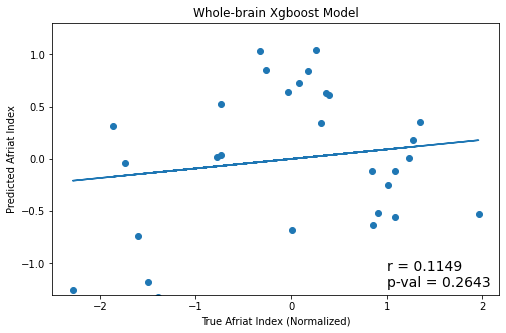

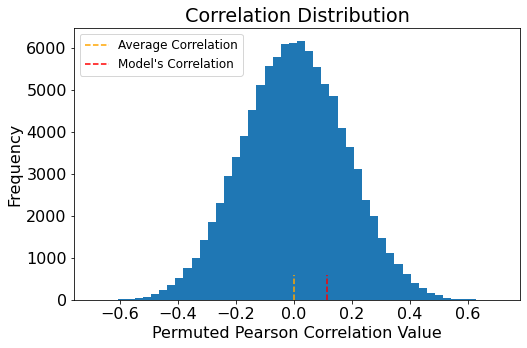

In [49]:
# Schaefer Xgboost with Hyperparameter
xgb_coef_schaefer, xgb_sch_y_hats, xgb_sch_y_true, xgb_models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Xgboost')
r, pval = print_results(xgb_sch_y_true, xgb_sch_y_hats, inconsistency_measure, 'Whole-brain Xgboost')
xgb_sch_avg, xgb_sch_score = average_coefs(xgb_coef_schaefer)
print(f'MSE: {xgb_sch_score:.3f}')
draw_glassbrain(xgb_sch_avg[:5].reset_index(drop=True))

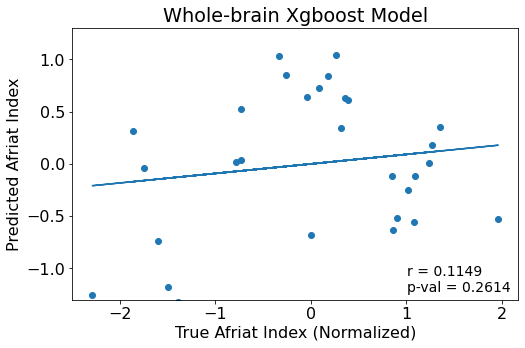

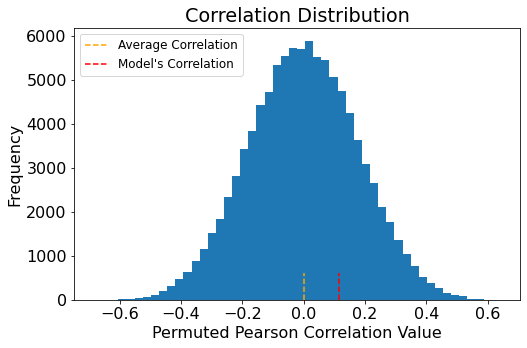

In [51]:
r, pval = print_results(xgb_sch_y_true, xgb_sch_y_hats, inconsistency_measure, 'Whole-brain Xgboost')


## Plot Results on Brain

In [57]:
import nibabel as nib

In [58]:
sch_labels_path = '/Users/elaine/Downloads/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii'
labels = nib.load(sch_labels_path)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [59]:
# initiate atlas and labels
with open("../data/Schaefer2018_100Parcels_7Networks_order_info.txt", 'r') as f:
    parcels_text = f.read()
# select only even rows, which contain the labels 
lines = parcels_text.split('\n')[:-1]
lines = lines[::2]
# remove prefix from label: "7Networks_"
parcel_list = [parcel[10:] for parcel in lines]

In [60]:
importance_df = sch_avg_forest
# fdata = labels.get_fdata()

for i in range(len(importance_df)):
    # extract each node's name (splitted by "__")
    node1_name = importance_df.loc[i, 'Feature'].split('__')[0]
    node2_name = importance_df.loc[i, 'Feature'].split('__')[1] 
    importance_df.loc[i, 'Node1'] = int(parcel_list.index(node1_name)+1)
    importance_df.loc[i, 'Node2'] = int(parcel_list.index(node2_name)+1)

# create features matrix
node_number = 100
features_matrix = np.zeros([node_number, node_number])
for i in range(len(importance_df)):
    # get the indices of nodes
    node1, node2 = importance_df.iloc[i, 2], importance_df.iloc[i, 3]
    # put the value/beta/importance of nodes in the cifti data
    # fdata[0, np.where((fdata==node1) | (fdata==node2))] = importance_df.iloc[i, 1]

In [61]:
importance_df.to_csv('../data/schaefer_forest_importance_grid_LOO.csv')

## Structural Connectivity

In [38]:
import get_structural_matrix
import glob
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [39]:
import importlib
importlib.reload(get_structural_matrix)

<module 'get_structural_matrix' from 'c:\\Users\\Asaf\\Documents\\Asaf\\python\\inconsistency_functional_connectivity\\code\\get_structural_matrix.py'>

In [40]:
def get_subject_full_cm(path, pass_end, measure, subject):
    subject_file = glob.glob(f'{path}/{subject}*_{measure}_{pass_end}.mat')[0]
    cm = scipy.io.loadmat(subject_file)['CM']
    return cm

c:\Users\Asaf\Documents\Asaf\python\inconsistency_functional_connectivity\code\get_structural_matrix.py:41: RuntimeWarning: Mean of empty slice
  avg_cm = np.nanmean([scipy.io.loadmat(path)['CM'] for path in paths], axis=0)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


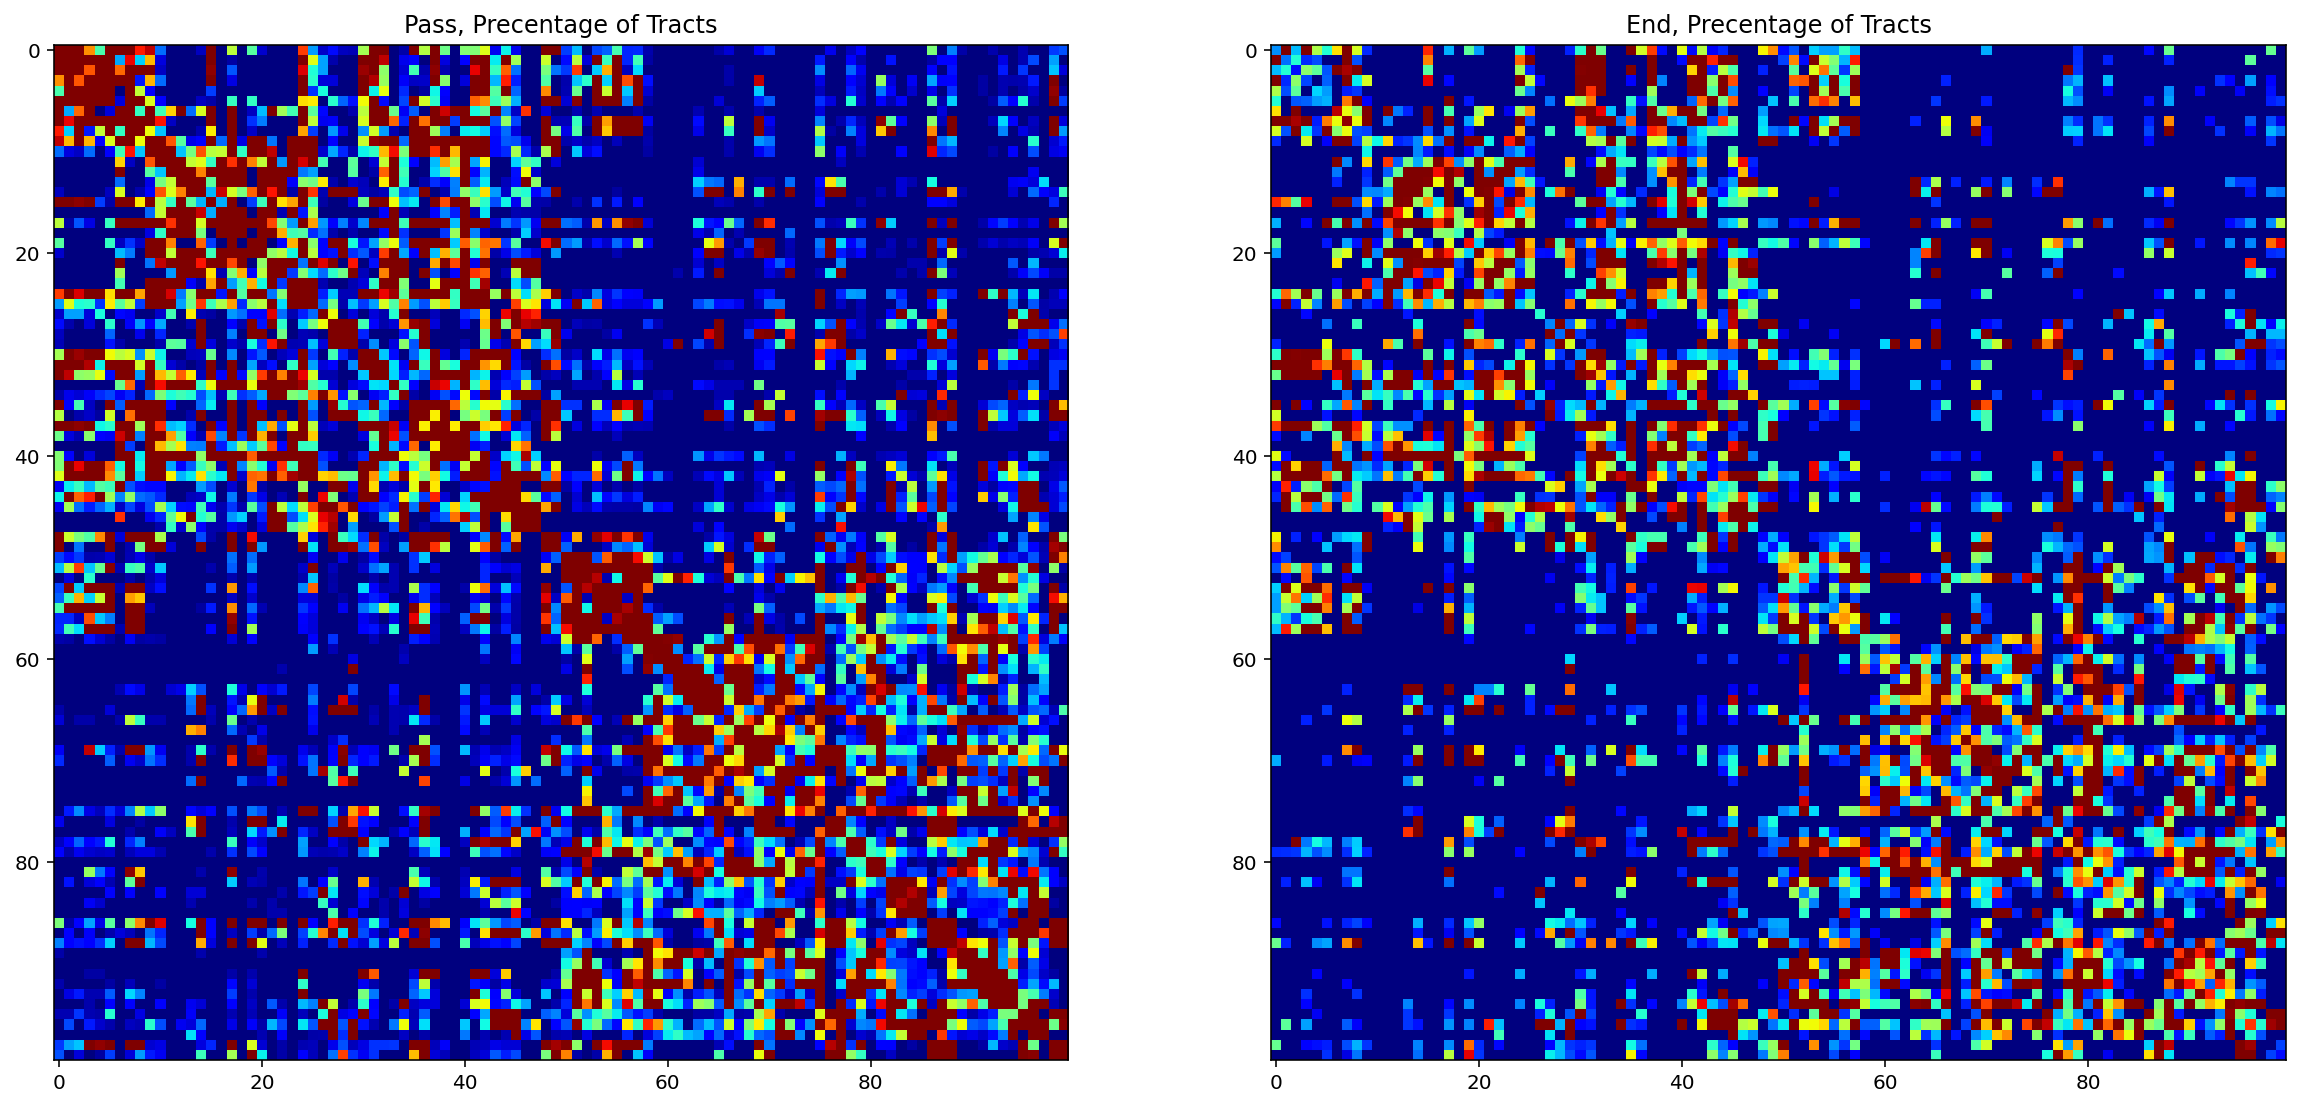

In [41]:
avg_cm = get_structural_matrix.get_avg_cm('../data/structural', 'PASS', 'percentage_of_tracts')
avg_cm = np.nan_to_num(avg_cm)
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.imshow(avg_cm, cmap='jet', vmax=0.001)
_ = plt.title('Pass, Precentage of Tracts')

avg_cm = get_structural_matrix.get_avg_cm('../data/structural', 'END', 'percentage_of_tracts')
avg_cm = np.nan_to_num(avg_cm)
plt.subplot(1, 2, 2)
plt.imshow(avg_cm, cmap='jet', vmax=0.001)
# _ = plt.colorbar()
_ = plt.title('End, Precentage of Tracts')

In [42]:
path = '../data/structural'
measure = 'percentage_of_tracts'
pass_end = 'END'
paths = glob.glob(f'{path}/*_{measure}_{pass_end}.mat')
avg_cm = np.nanmean([scipy.io.loadmat(path)['CM'] for path in paths], axis=0)
avg_cm = np.nan_to_num(avg_cm)

C:\Users\Asaf\AppData\Local\Temp/ipykernel_1560/3149667159.py:5: RuntimeWarning: Mean of empty slice
  avg_cm = np.nanmean([scipy.io.loadmat(path)['CM'] for path in paths], axis=0)


In [43]:
dti_path = '../data/structural'
fa_df = get_structural_matrix.get_cm_df(dti_path, 'PASS', 'FA')
fa_df = fa_df.dropna(axis=1, how='all')
fa_df = fa_df.fillna(0)

In [44]:
X_fa = fa_df
# choose only subjects that did a resting scan
Ys_fa = behavioral_results.loc[fa_df.index]
# shorten names of variables
Ys_fa = Ys_fa.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']
# remove perfectly-consistent subjects
inconsistent_subjects_fa = Ys_fa.loc[:, 'GARP Violations']!=0
Ys_fa_incon = Ys_fa.loc[inconsistent_subjects_fa, :]
X_fa_incon = X_fa.loc[inconsistent_subjects_fa, :]

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_39055/1599848282.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis='both')
/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 1.161


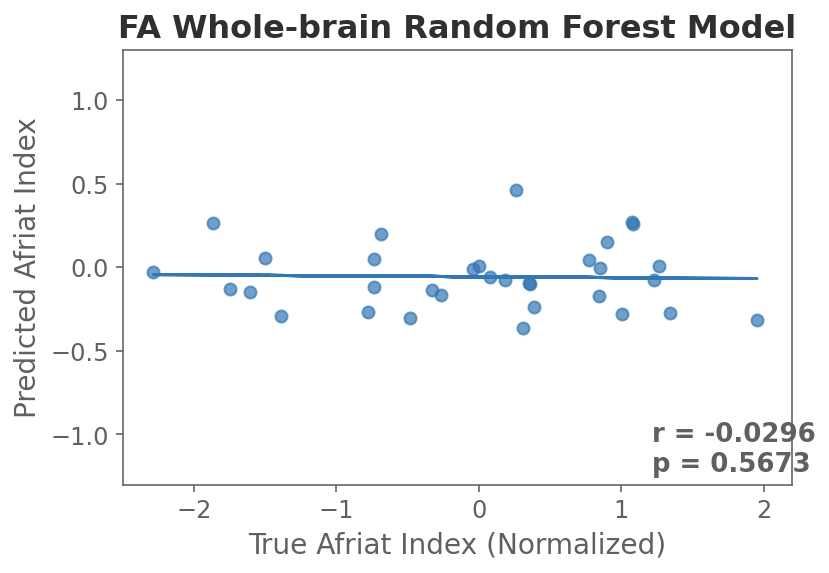

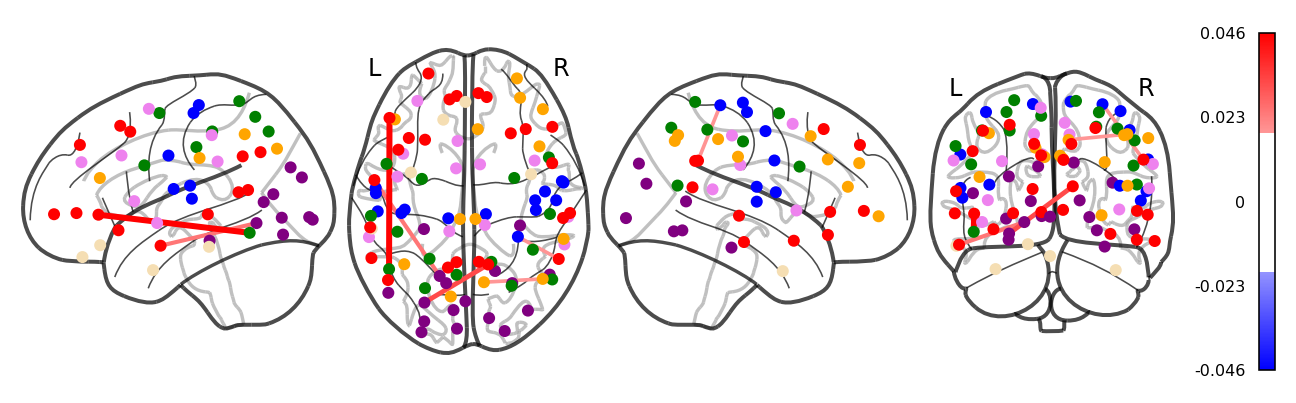

In [73]:
# Schaefer Random Forest with Hyperparameter
rf_fa_coef, rf_fa_y_hats, rf_fa_y_true, fa_models = random_forest_model(fa_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest')
r_fa, pval_fa = print_results(rf_fa_y_true, rf_fa_y_hats, inconsistency_measure, 'FA Whole-brain Random Forest')
fa_avg_forest, fa_forest_score = average_coefs(rf_fa_coef)
print(f'MSE: {fa_forest_score:.3f}')
draw_glassbrain(fa_avg_forest[:5].reset_index(drop=True))

In [283]:
dti_path = '../data/structural'
tracts_df = get_structural_matrix.get_cm_df(dti_path, 'PASS', 'percentage_of_tracts')

In [284]:
# tracts_df = tracts_df.dropna(axis=1, how='all')
# tracts_df = tracts_df.fillna(0)

In [285]:
tracts_df = tracts_df.dropna(axis=1)

Fold: 1/33, Time: 13:06:39 03/09/22
Fold: 2/33, Time: 13:07:36 03/09/22
Fold: 3/33, Time: 13:08:29 03/09/22
Fold: 4/33, Time: 13:09:23 03/09/22
Fold: 5/33, Time: 13:10:18 03/09/22
Fold: 6/33, Time: 13:11:11 03/09/22
Fold: 7/33, Time: 13:12:07 03/09/22
Fold: 8/33, Time: 13:13:01 03/09/22
Fold: 9/33, Time: 13:13:55 03/09/22
Fold: 10/33, Time: 13:14:49 03/09/22
Fold: 11/33, Time: 13:15:43 03/09/22
Fold: 12/33, Time: 13:16:37 03/09/22
Fold: 13/33, Time: 13:17:30 03/09/22
Fold: 14/33, Time: 13:18:26 03/09/22
Fold: 15/33, Time: 13:19:20 03/09/22
Fold: 16/33, Time: 13:20:15 03/09/22
Fold: 17/33, Time: 13:21:11 03/09/22
Fold: 18/33, Time: 13:22:07 03/09/22
Fold: 19/33, Time: 13:23:03 03/09/22
Fold: 20/33, Time: 13:23:58 03/09/22
Fold: 21/33, Time: 13:24:54 03/09/22
Fold: 22/33, Time: 13:25:49 03/09/22
Fold: 23/33, Time: 13:26:47 03/09/22
Fold: 24/33, Time: 13:27:42 03/09/22
Fold: 25/33, Time: 13:28:38 03/09/22
Fold: 26/33, Time: 13:29:33 03/09/22
Fold: 27/33, Time: 13:30:28 03/09/22
Fold: 28/3

C:\Users\Asaf\miniconda3\envs\fc_inconsistency\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


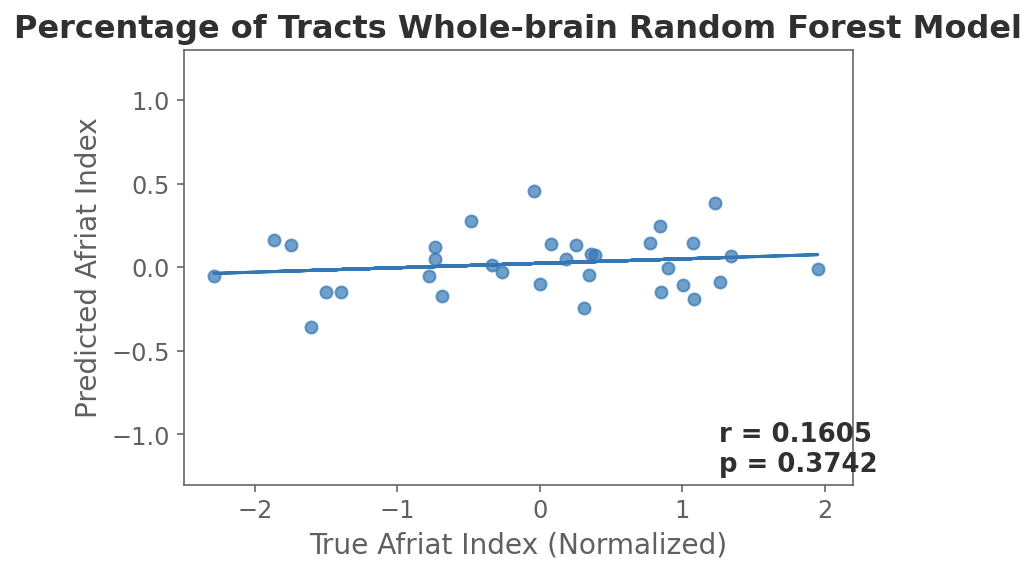

In [286]:
# Schaefer Random Forest with Hyperparameter
rf_pt_coef, rf_pt_y_hats, rf_pt_y_true, pt_models = random_forest_model(tracts_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest', k_cv=4)
r_pt, pval_pt = print_results(rf_pt_y_true, rf_pt_y_hats, inconsistency_measure, 'Percentage of Tracts Whole-brain Random Forest')
pt_avg_forest, pt_forest_score = average_coefs(rf_pt_coef)
print(f'MSE: {pt_forest_score:.3f}')
# draw_glassbrain(pt_avg_forest[:5].reset_index(drop=True))

In [81]:
dti_path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/PASS'
MD_df = get_structural_matrix.create_structural_matrix_df(dti_path, 'PASS', 'MD')

In [83]:
MD_df = MD_df.set_index(p_tracts_df.index.astype(int))
MD_df = MD_df.dropna(axis=1, how='all')
MD_df = MD_df.fillna(0)

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_39055/1599848282.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis='both')
/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 1.078


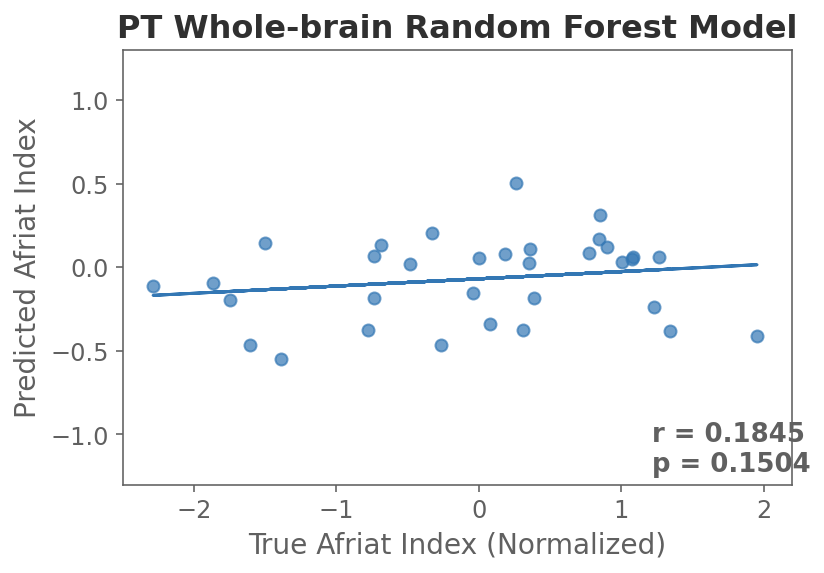

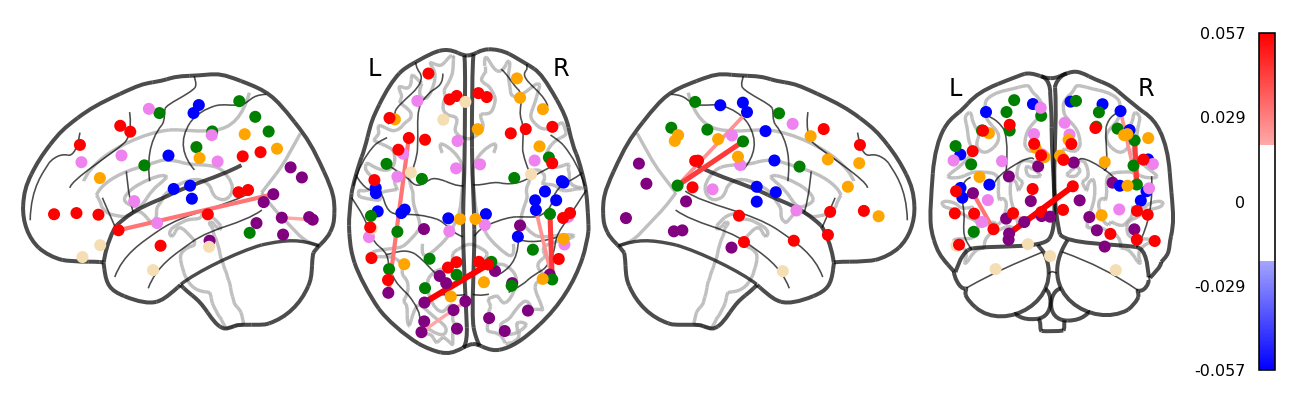

In [84]:
# Schaefer Random Forest with Hyperparameter
rf_md_coef, rf_md_y_hats, rf_md_y_true, md_models = random_forest_model(MD_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest')
r_md, pval_md = print_results(rf_md_y_true, rf_md_y_hats, inconsistency_measure, 'PT Whole-brain Random Forest')
md_avg_forest, md_forest_score = average_coefs(rf_md_coef)
print(f'MSE: {md_forest_score:.3f}')
draw_glassbrain(md_avg_forest[:5].reset_index(drop=True))

## Combined Strctural-Functional Model

In [265]:
schaefer_mat_scaled = (schaefer_mat.transpose()-np.mean(schaefer_mat, axis=1))/np.std(schaefer_mat, axis=1)
schaefer_mat_scaled = schaefer_mat_scaled.transpose()

tracts_df_scaled = (tracts_df.transpose()-np.mean(tracts_df, axis=1))/np.std(tracts_df, axis=1)
tracts_df_scaled = tracts_df_scaled.transpose()


In [266]:
X_combined = pd.merge(schaefer_mat_scaled, tracts_df_scaled, right_index=True, left_index=True, suffixes=['-F', '-S'])

In [258]:
A = X_combined==0
X_combined = X_combined.drop(labels = X_combined.columns[A.all()], axis=1)

Fold: 1/32, Time: 10:03:35 03/08/22
Fold: 2/32, Time: 10:37:58 03/08/22
Fold: 3/32, Time: 11:11:09 03/08/22
Fold: 4/32, Time: 11:42:10 03/08/22
Fold: 5/32, Time: 12:11:46 03/08/22
Fold: 6/32, Time: 12:40:47 03/08/22
Fold: 7/32, Time: 13:09:31 03/08/22
Fold: 8/32, Time: 13:37:52 03/08/22
Fold: 9/32, Time: 14:06:03 03/08/22
Fold: 10/32, Time: 14:34:09 03/08/22
Fold: 11/32, Time: 15:01:52 03/08/22
Fold: 12/32, Time: 15:29:42 03/08/22
Fold: 13/32, Time: 15:57:16 03/08/22
Fold: 14/32, Time: 16:25:20 03/08/22
Fold: 15/32, Time: 16:53:43 03/08/22
Fold: 16/32, Time: 17:21:35 03/08/22
Fold: 17/32, Time: 17:49:16 03/08/22
Fold: 18/32, Time: 18:17:01 03/08/22
Fold: 19/32, Time: 18:45:16 03/08/22
Fold: 20/32, Time: 19:13:02 03/08/22
Fold: 21/32, Time: 19:40:51 03/08/22
Fold: 22/32, Time: 20:08:22 03/08/22
Fold: 23/32, Time: 20:35:43 03/08/22
Fold: 24/32, Time: 21:03:36 03/08/22
Fold: 25/32, Time: 21:32:15 03/08/22
Fold: 26/32, Time: 21:59:52 03/08/22
Fold: 27/32, Time: 22:27:25 03/08/22
Fold: 28/3

C:\Users\Asaf\miniconda3\envs\fc_inconsistency\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


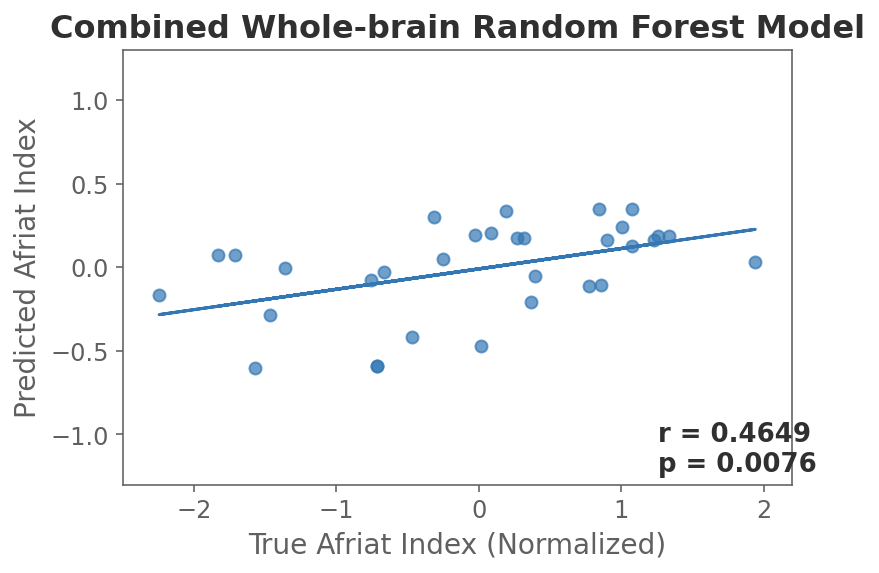

In [267]:
# Combined Schaefer Random Forest 
rf_combined_df, rf_combined_y_hats, rf_combined_y_true, rf_combined_models = random_forest_model(X_combined.loc[inconsistent_subjects, :], Ys.loc[X_combined.loc[inconsistent_subjects, :].index, :], inconsistency_measure, 'RandomForest', k_cv=31, scale_x=0)
r, pval = print_results(rf_combined_y_true, rf_combined_y_hats, inconsistency_measure, 'Combined Whole-brain Random Forest')
combined_avg_forest, combined_forest_score = average_coefs(rf_combined_df)
print(f'MSE: {combined_forest_score:.3f}')

In [282]:
combined_avg_forest

,Feature,Beta
5373,LH_Default_pCunPCC_1__LH_SomMot_6,0.148558
5372,RH_SomMot_8__LH_Default_pCunPCC_1,0.022088
5371,LH_Cont_Cing_1__LH_Cont_Par_1,0.017507
5370,RH_Default_Temp_3__LH_SalVentAttn_Med_1,0.017318
5369,RH_SalVentAttn_TempOccPar_1__LH_SalVentAttn_Pa...,0.015744
...,...,...
1117,RH_Cont_Cing_1__RH_Vis_2,0.0
1118,RH_Cont_Cing_1__RH_Vis_5,0.0
1119,RH_Cont_Cing_1__RH_Vis_8,0.0
1120,RH_Cont_PFCmp_1__LH_DorsAttn_Post_3,0.0


## Node degree instead of FC edges

In [180]:
X_degree = pd.read_csv('../data/schaefer_fc_degree.csv', index_col='Subject')

Fold: 1/33, Time: 12:41:08 03/03/22
Fold: 2/33, Time: 12:47:15 03/03/22
Fold: 3/33, Time: 12:53:12 03/03/22
Fold: 4/33, Time: 12:59:10 03/03/22
Fold: 5/33, Time: 13:05:13 03/03/22
Fold: 6/33, Time: 13:11:27 03/03/22
Fold: 7/33, Time: 13:17:30 03/03/22
Fold: 8/33, Time: 13:23:27 03/03/22
Fold: 9/33, Time: 13:29:24 03/03/22
Fold: 10/33, Time: 13:35:22 03/03/22
Fold: 11/33, Time: 13:41:19 03/03/22
Fold: 12/33, Time: 13:47:16 03/03/22
Fold: 13/33, Time: 13:53:16 03/03/22
Fold: 14/33, Time: 13:59:12 03/03/22
Fold: 15/33, Time: 14:05:08 03/03/22
Fold: 16/33, Time: 14:11:05 03/03/22
Fold: 17/33, Time: 14:17:04 03/03/22
Fold: 18/33, Time: 14:23:01 03/03/22
Fold: 19/33, Time: 14:29:01 03/03/22
Fold: 20/33, Time: 14:35:10 03/03/22
Fold: 21/33, Time: 14:42:38 03/03/22
Fold: 22/33, Time: 14:49:13 03/03/22
Fold: 23/33, Time: 14:56:15 03/03/22
Fold: 24/33, Time: 15:02:32 03/03/22
Fold: 25/33, Time: 15:08:48 03/03/22
Fold: 26/33, Time: 15:15:07 03/03/22
Fold: 27/33, Time: 15:21:28 03/03/22
Fold: 28/3

C:\Users\Asaf\miniconda3\envs\fc_inconsistency\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


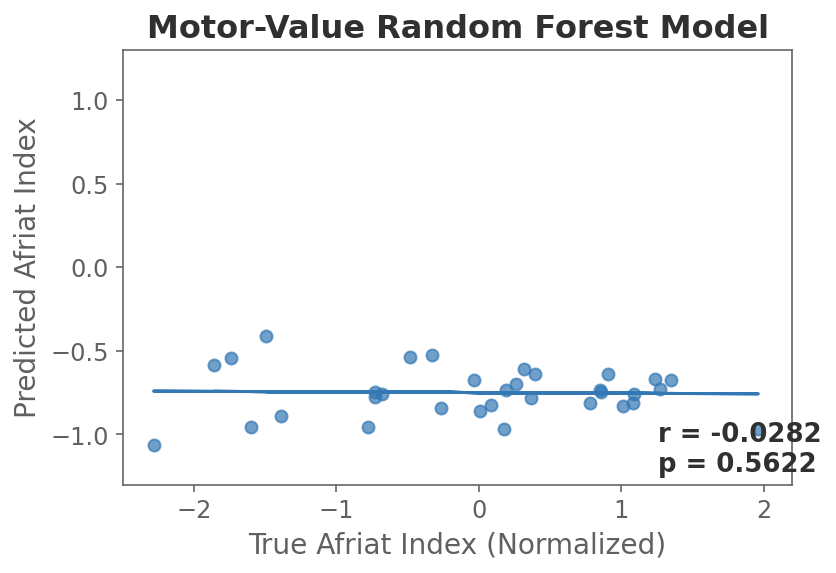

In [188]:
# Node-degree Random Forest
coef_df_degree, degree_y_hats, degree_y_true, degree_models = random_forest_model(X_degree.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest', k_cv=32, scale_x=2)
r, pval = print_results(degree_y_true, degree_y_hats, inconsistency_measure, 'Motor-Value Random Forest')
degree_avg_forest, degree_forest_score = average_coefs(coef_df_degree)
print(f'MSE: {degree_forest_score:.3f}')

# Classification of Inconsistency

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn import svm

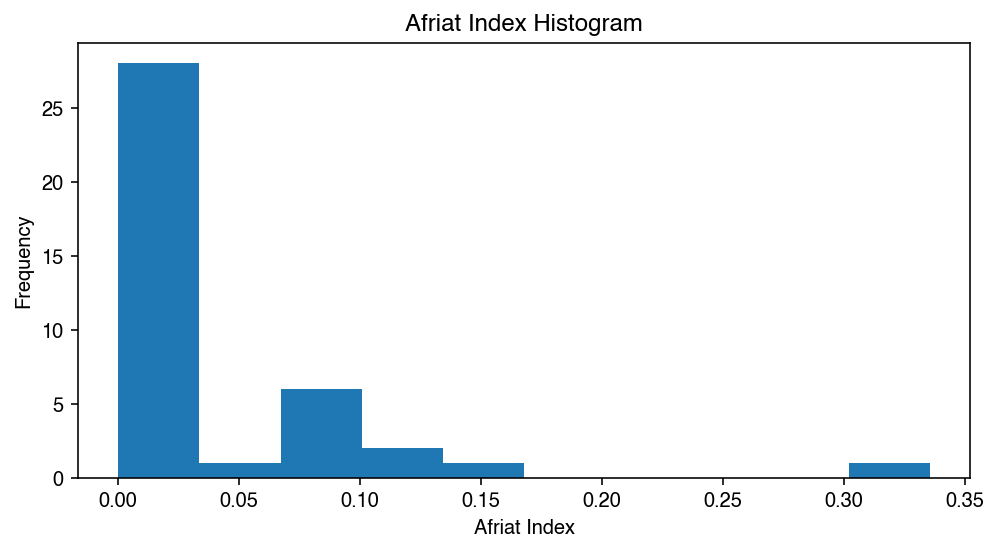

In [160]:
plt.figure(figsize = (8, 4))
plt.hist(Ys[inconsistency_measure])
plt.title(inconsistency_measure + ' Histogram')
plt.ylabel('Frequency')
plt.xlabel(inconsistency_measure)
Ys['Inconsistent'] = Ys[inconsistency_measure] > np.median(Ys[inconsistency_measure])
y_true = Ys['Inconsistent']

In [161]:
def select_features_class(X, y, feature_number):
    f_scores, _ = f_classif(X, y)
    sort_ind = np.argsort(f_scores)
    sorted_features = X.columns[sort_ind]
    selected_features = sorted_features[-1*feature_number:]
    return selected_features

In [162]:
def linear_classifier(X, y, model_type, feature_number):
    '''
    Trains a model: Logistic Regression. 
    Split train/test, selects features and predicts in with a leave-one-out procedure
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - pandas DataFrame
                DataFrame of target vairables
            measure - string
                name of target variable
            model_type - string
                string of model type, either:
                    'Logistic' - regular logistic regression
            feature_number - int
                number of features to select

    Returns
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
            y_hats - float array
                predicted target values
            y_true - float array
                true target values
            models - sklearn regressors list
                list of models used in the leave-one-out procedure
    '''
    
    models = []
    scores = []
    
    # initiate models, based on model_type
    if model_type == 'Logistic':
#         model = LogisticRegressionCV(cv = 3, n_jobs = -1, random_state = 42, max_iter = 50000, penalty = 'elasticnet', 
#                                      solver = 'saga', l1_ratios = np.arange(0.01, 1, 0.02))
        model = LogisticRegressionCV(cv = 2, n_jobs = -1, random_state = 42, max_iter = 50000)

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        if model_type != 'Xgboost':
            # select top N features with highest correlation with y_train
            selected_features = select_features_class(X_train, y_train, feature_number)

            X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        # save the models, scores and predicted values
        models.append(model)
        score = int(y_test != y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])
        coefs = model.coef_
        coef_df['Coefficient'] = np.append(coefs, score)
        # each model might have different sets of features, so we append all DataFrames to a list 
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [163]:
def build_classifier(X, y, model_type, k_cv=3):
    
    models = []
    scores = []
    
    n_estimators = [int(x) for x in np.linspace(60, 250, 10)]
    n_estimators.append(100)
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 100, 5)]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2]
    learning_rate = [1, 2, 3]
    param_grid = {'n_estimators' : n_estimators,
                 'max_features' : max_features,
                 'max_depth' : max_depth,
                 'min_samples_split' : min_samples_split,
                 'min_samples_leaf' : min_samples_leaf}
    if model_type == 'Xgboost':
        model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
        param_grid = {'n_estimators' : n_estimators,
                      'max_depth' : max_depth,
                      'learning_rate' : learning_rate}
        model_cv = GridSearchCV(model, param_grid=param_grid, cv=k_cv) 
    else:
        if model_type == 'RandomForest':
            model = RandomForestClassifier(n_jobs = -1, random_state = 42)
            model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv) 

    
    features = X.columns
    features = features.append(pd.Index(['Score']))
    coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        current_time = datetime.datetime.strftime(datetime.datetime.now(), '%H:%M:%S %D')
        print(f'Fold: {i}/{len(y)}, Time: {current_time}')
        
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        
        model_cv.fit(X_train, y_train)
        best_model = model_cv.best_estimator_
        
        y_pred = best_model.predict(X_test)
        models.append(best_model)
        score = int(y_test != y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        if model_type != 'SVM':
            coefs = pd.DataFrame(best_model.feature_importances_)
            coef_df['Coefficient' + str(i)] = np.append(coefs, score)
            coefs_list = coef_df
        i += 1
    return coefs_list, y_hats, y_true, models

In [223]:
def accuracy_permuation(y_pred, y_true):
    '''
    ----
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
        
    Returns
    ----------------------------
        acc - float

        pval - float

    '''
    permutations = 100000
    acc = metrics.accuracy_score(y_true, y_pred)
    y_pred_permute = y_pred.copy()
    acc_distribution = []

    for i in range(permutations):
        # for each permuation shuffle the predicted values between subjects, and calculate accuracy with the true values 
        random.shuffle(y_pred_permute)
        this_acc = metrics.accuracy_score(y_pred_permute, y_true)
        acc_distribution.append(this_acc)
        
    pval = sum(acc <= acc_distribution) / len(acc_distribution)
    return acc, pval, acc_distribution

In [227]:
def print_accuracy_results(y_pred, y_true, plot_dist=0):
    acc, pval, acc_dist = accuracy_permuation(y_pred, y_true)
    conf_mat = confusion_matrix(y_true, y_pred)
    cm_disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Consistent', 'Inconsistent'])
    cm_disp.plot(cmap='Blues')
    plt.ylabel('True', rotation=90, fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    if plot_dist:
        plot_distribution(acc, acc_dist, pval, 'Accuracy', 11)


### Xgboost

In [62]:
# Xgboost - Motor-value
mv_xgb_coef, mv_xgb_y_hat, mv_xgb_y_true, mv_xgb_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Xgboost')
print(f'Xgboost Accuracy: {metrics.accuracy_score(mv_xgb_y_true, mv_xgb_y_hat)}')
mv_acc, mv_acc_pval, mv_acc_dist = accuracy_permuation(mv_xgb_y_hat, mv_xgb_y_true)
print(f'p-val of accuracy: {mv_acc_pval}')

In [26]:
# Xgboost - Schaefer
#xgb_coef, xgb_y_hat, xgb_y_true, xgb_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Xgboost', k_cv=16)
print(f'Xgboost Accuracy: {metrics.accuracy_score(xgb_y_true, xgb_y_hat)}')
avg_xgb_coefs, _ = average_coefs(xgb_coef)
print(f'Top coefficients: {avg_xgb_coefs[:5]}')
acc, acc_pval, acc_dist = accuracy_permuation(xgb_y_hat, xgb_y_true)


Fold: 1/33, Time: 17:08:38 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 2/33, Time: 18:16:00 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 3/33, Time: 19:23:41 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 4/33, Time: 20:31:10 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 5/33, Time: 21:39:43 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 6/33, Time: 22:47:13 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 7/33, Time: 23:54:38 01/24/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 8/33, Time: 01:02:12 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 9/33, Time: 02:09:41 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 10/33, Time: 03:17:06 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 11/33, Time: 04:24:29 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 12/33, Time: 05:31:35 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 13/33, Time: 06:38:44 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 14/33, Time: 07:46:06 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 15/33, Time: 08:53:36 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 16/33, Time: 10:01:17 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 17/33, Time: 11:07:17 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 18/33, Time: 12:13:14 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 19/33, Time: 13:19:08 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 20/33, Time: 14:24:55 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 21/33, Time: 15:30:41 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 22/33, Time: 16:36:26 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 23/33, Time: 17:42:11 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 24/33, Time: 18:47:53 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 25/33, Time: 19:53:31 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 26/33, Time: 20:59:13 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 27/33, Time: 22:04:55 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 28/33, Time: 23:10:34 01/25/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 29/33, Time: 00:16:15 01/26/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Fold: 30/33, Time: 01:21:56 01/26/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 31/33, Time: 02:27:40 01/26/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 32/33, Time: 03:33:24 01/26/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 13 members, which is less than n_splits=16.
  warnings.warn(


Fold: 33/33, Time: 04:39:11 01/26/22


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 14 members, which is less than n_splits=16.
  warnings.warn(


Xgboost Accuracy: 0.7575757575757576
Top coefficients:                                      Feature      Beta
4949          RH_Cont_PFCl_3__RH_Cont_PFCl_1  0.440729
4948            LH_DorsAttn_Post_4__LH_Vis_9  0.231666
4947  RH_DorsAttn_Post_4__RH_DorsAttn_Post_1  0.118169
4946       LH_Default_pCunPCC_1__LH_SomMot_6  0.053464
4945                   RH_SomMot_2__LH_Vis_2   0.02189


/Users/elaine/opt/miniconda3/envs/fc_incon/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


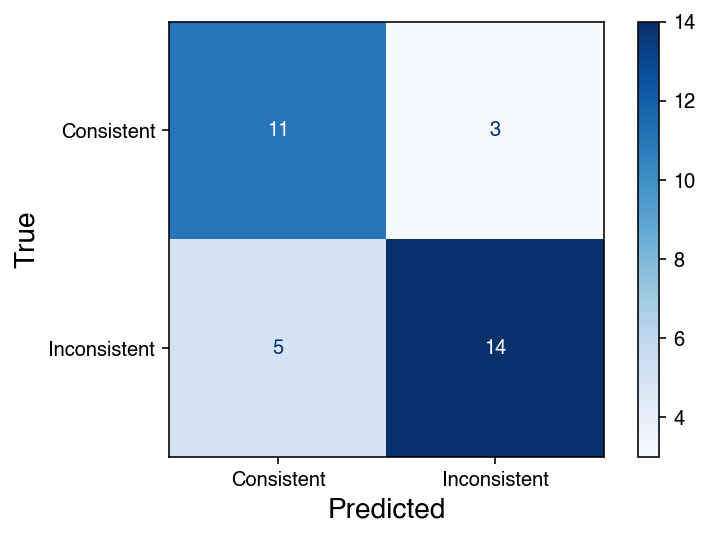

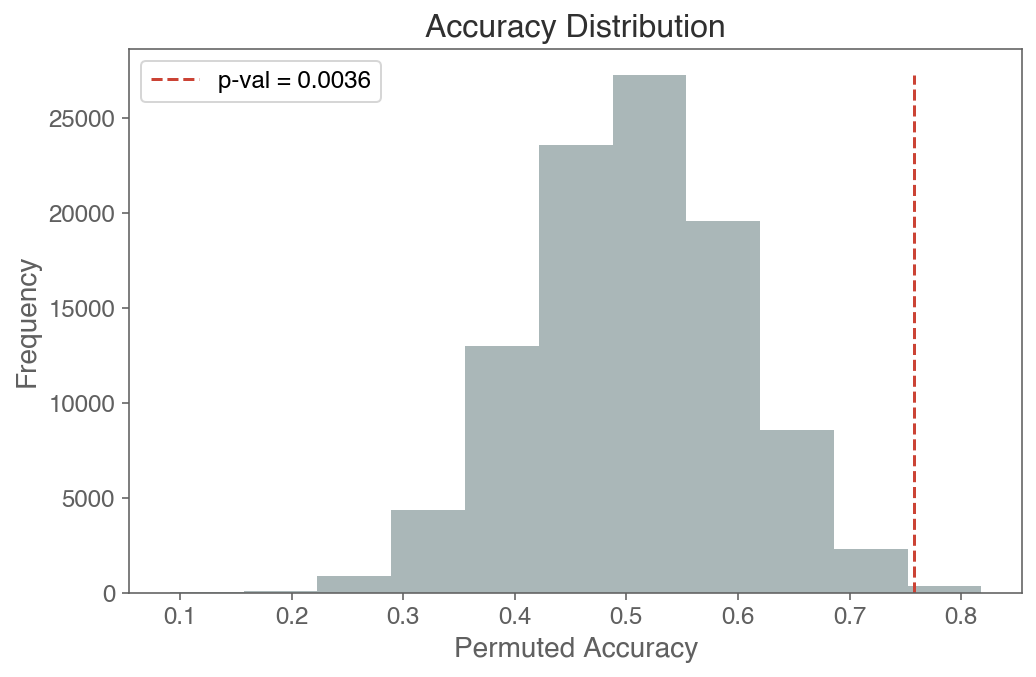

In [228]:
print_accuracy_results(xgb_y_hat, xgb_y_true, 1)

### SVM

In [628]:
_, sch_svm_y_hats, sch_svm_y_true, sch_svm_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'SVM')
print(f'SVM Accuracy: {metrics.accuracy_score(sch_svm_y_true, sch_svm_y_hats)}')
sch_svm_acc, sch_svm_acc_pval, sch_svm_acc_dist = accuracy_permuation(sch_svm_y_hats, sch_svm_y_true)
print(f'p-val of accuracy: {sch_svm_acc_pval}')

SVM Accuracy: 0.6666666666666666
p-val of accuracy: 0.09039


In [609]:
_, mv_svm_y_hats, mv_svm_y_true, mv_svm_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'SVM')
print(f'SVM Accuracy: {metrics.accuracy_score(mv_svm_y_true, mv_svm_y_hats)}')
mv_svm_acc, mv_svm_acc_pval, mv_svm_acc_dist = accuracy_permuation(mv_svm_y_hats, mv_svm_y_true)
print(f'p-val of accuracy: {mv_svm_acc_pval}')

### Gradient Boosting

In [114]:
# Gradient Boosting classifier - Motor value
gb_class, gb_y_hat, gb_y_true, gb_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'GradientBoosting')
print(f'Gradient Boosting Accuracy: {metrics.accuracy_score(gb_y_hat, gb_y_true)}')

Gradient Boosting Accuracy: 0.48484848484848486


In [702]:
# Gradient Boosting classifier
gb_class, gb_y_hat, gb_y_true, gb_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'GradientBoosting')
print(f'Gradient Boosting Accuracy: {metrics.accuracy_score(gb_y_hat, gb_y_true)}')

Gradient Boosting Accuracy: 0.6666666666666666


### Random Forest

In [701]:
# Random Forest classifier
rf_class, rf_y_hat_class, rf_y_true_class, rf_class_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'RandomForest')
print(f'Random Forest Accuracy: {metrics.accuracy_score(rf_y_hat_class, rf_y_true_class)}')


Random Forest Accuracy: 0.6060606060606061


### Logistic Regression

In [885]:
# Logistic regression 
logi_coef, logi_y_hat, logi_y_True, logi_models = linear_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Logistic', 45)
print(f'Logistic Regression Accuracy: {metrics.accuracy_score(logi_y_True, logi_y_hat)}')

Logistic Regression Accuracy: 0.5757575757575758


# FDR

In [30]:
ps = [0.00398, 0.0106, 0.0230, 0.0384, 0.1898]
alpha = 0.05
n = len(ps)
rej = np.zeros(n)
for j in range(n):
    fdr = alpha * (j+1) / n
    print(fdr)
    if ps[j] < fdr:
        rej[j] = 1
rej

0.01
0.02
0.030000000000000006
0.04
0.05


array([1., 1., 1., 1., 0.])

### Dino's comments
### To do ###
1. Average matrices for value-motor and Schaefer
2. Check feature correlation matrix and remove highly correlated features
3. Interpretability - What is the relation between the connectivity and the inconsistency? Stronger -> less consistent

#### Done ###
1. Is the fisher transform necessary? - yes, affects results. why?
2. Check more models: Random Forrest, SVM?, Xgboost - RF is the best
3. X axis only negative - make sure the order is saved before and after transformation - the order is saved
4. Change axes values, so they make sense - fixed
5. Squared error - comparing models
6. Add a 45-angle line to compare - dismissed, doesn't look good
7. Draw glass brain 

## Vered's comments
#### Done ####
1. Correlation matrix for Inocnsistency measures
2. Draugowitz - 3 sources for inconsistency
3. Emily Finn - take only top correlations with the y

#### To do? #####
* transform measures to ordinary scale and correlate fc_matrix to ordinary scale
* predict task fmri form rest ??? - Consult with Ido
* Stepwise regression

## Unused - Multiple Regression of Varian ~ features

In [13]:
import statsmodels.api as sm

In [411]:
# Simple regression - Motor-value
measure = all_measures[2]
y = np.log(Ys_incon.loc[:, measure])
X = X_incon
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

                              OLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.980
Model:                               OLS   Adj. R-squared:                  0.837
Method:                    Least Squares   F-statistic:                     6.889
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):             0.0364
Time:                           16:20:21   Log-Likelihood:                -2.2787
No. Observations:                     33   AIC:                             62.56
Df Residuals:                          4   BIC:                             106.0
Df Model:                             28                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

In [547]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 45)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
lm = linear_model.LassoCV(max_iter = 50000, n_jobs = -1)
lm.fit(X, y)

LassoCV(max_iter=50000, n_jobs=-1)

In [557]:
X['Varian'] = y.values

In [558]:
# write X to csv for Rstudio
X.to_csv('/Users/elaine/Dropbox/LabDropbox/Asaf/python/whole_brain.csv')


                              WLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.974
Model:                               WLS   Adj. R-squared:                  0.582
Method:                    Least Squares   F-statistic:                     2.486
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):              0.328
Time:                           17:20:06   Log-Likelihood:                -6.4227
No. Observations:                     33   AIC:                             74.85
Df Residuals:                          2   BIC:                             121.2
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

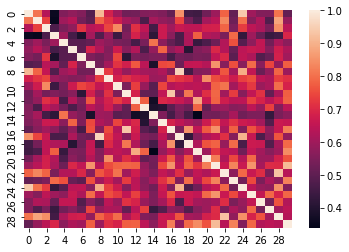

In [520]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 30)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
#X = (X - np.mean(X)) / np.std(X)
sns.heatmap(np.corrcoef(X.transpose()))
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

In [401]:
selected_features.get_loc('LH_Default_PFC_6_LH_Limbic_TempPole_2')

1

In [394]:
############## UNFINISHED - DOESN'T WORK
# def remove_multicollinearity(X):

selected_features = X.columns
count = 0
finished = 0
i = 1
while True:
    if i >= len(X.columns)-1:
        break
    else:
        if X.columns[i] not in selected_features:
            i += 1
        else:
            feature_i = X.columns[i]
            print(feature_i)
            data_i = X.loc[:, feature_i]
            j = selected_features.get_loc(feature_i) + 1
            while True:
                if j >= len(selected_features):
                    break
                else:
                    feature_j = selected_features[j]
                    data_j = X.loc[:, feature_j]
                    cor_ij = np.corrcoef(data_i, data_j)[0, 1]
                    if cor_ij > 0.7:
                        selected_features = selected_features.drop(feature_j)
                        count += 1
                    j += 1
            i += 1
#    return selected_features

LH_Default_PFC_6_LH_Limbic_TempPole_2
LH_Default_pCunPCC_2_LH_SomMot_2
RH_Default_Temp_2_RH_SomMot_8
RH_Default_pCunPCC_1_RH_SomMot_6
RH_Limbic_OFC_1_LH_DorsAttn_Post_5
LH_Cont_Cing_1_LH_SomMot_6
RH_SomMot_8_LH_Limbic_OFC_1
RH_Limbic_OFC_1_RH_SalVentAttn_TempOccPar_2
RH_Default_pCunPCC_1_RH_SalVentAttn_Med_2
LH_Default_PFC_3_LH_SomMot_1
RH_DorsAttn_Post_5_LH_Limbic_OFC_1
RH_Limbic_TempPole_1_RH_DorsAttn_Post_5
RH_SalVentAttn_Med_2_LH_Default_PFC_3
